In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../settings/plot_style.mplstyle')

In [2]:
import numpy as np
import pandas as pd

clrs = np.array(['#003057', '#EAAA00', '#4B8B9B', '#B3A369', '#377117', '#1879DB', '#8E8B76', '#F5D580', '#002233', '#808080'])

# Clustering

Another common strategy for exploring datasets is to find "clusters" of similar datapoints. This is an unsupervised approach that can help identify patterns in low or high dimensions. This lecture will cover basic considerations and concepts in clustering data, and introduce a few basic classes of algorithms along with examples.

## Clustering Overview

### Problem statement

Clustering algorithms seek to identify data points that are similar to each other based on a set of descriptive features.

Clustering algorithms are **unsupervised** since they do not include output labels. The goal is to extract insight about the dataset based on its inherent structure, rather than to build a model that predicts an output. 

Some common uses for clustering include:

* data compression
* group/class assignment
* searching high-dimensional data
* feature identification
* learning probability distributions
* outlier detection

We will discuss some of these applications, but the same algorithms can be applied in many different ways to solve different problems that we may not discuss.



### Types of problems/algorithms

There are a few key types of clustering algorithms:

**Expectation-maximization** algorthims iteratively compute "expected" clusters and then "maximize" the parameters of the cluster to optimize the expectations. This is somewhat similar to an iterative version of a generalized linear classification algorithm: "classes" are assigned, then boundaries are found to optimize a cost function based on these classes. After this optimization the new class boundaries are used to assign classes again, and the optimization is repeated with new "class" labels.

**Density-based** algorithms utilize local information about data points to identify regions where the data has similar density. Regions where there is substantially lower density of data form boundaries between these clusters. This is somewhat similar to k-nearest neighbors where classes are defined by local environments.

**Hierarchical** algorithms map out the full network of connectivity within a dataset, then use a variable distance cutoff to assign clusters. These algorithms can be understood visually through a dendrogram, and have relatively few hyperparameters but they are more computationally demanding.

A few considerations when selecting a clustering algorithm:

* Some algorithms require defining the number of clusters explicitly (e.g. most expectation-maximization algorithms) while others find this implicitly based on choice of hyperparameters (e.g. density-based or hierarchical)

* Some algorithms allow **mixed membership** where points can belong to multiple clusters based on probabilities.

* Some algorithms can identify/ignore outliers/noise (e.g. density-based), while others attempt to assign clusters to all points (e.g. expectation-maximization and hierarchical).

## Accuracy and distance metrics

Computing the accuracy of unsupervised models is difficult because there is no "right answer". However, it is possible to compute some quantitative metrics based on the concept of a cluster.

* **Silhouette score** is defined for *each point* and is related to two distances:
    - $a$ is the average distance between a point and all other points in its cluster
    - $b$ is the average distance between a point and the points in the next nearest cluster
    - $S = \frac{b-a}{max(a,b)}$ is the silhoutte score
    - $S = -1$ implies totally incorrect, $S=1$ implies totally correct
    - Works best for dense, well-separated clusters
    - Does not work well for density-based clusters (e.g. DBSCAN)
    
The silhouette score can help identify individual points that are not well-clustered, or an average/max silhouette score can be used to evaluate the quality of the entire clustering model. Other metrics can be used to evaluate the overall model:

* **Variance ratio criterion** or "Calinski-Harabasz score" is related to the "within class" variance (similar to intra-class variance for classificaiton) and the "between class" variance (similar to the interclass variance for classification). The mathematical definition is available [here](https://www.tandfonline.com/doi/abs/10.1080/03610927408827101) but is beyond the scope of this course.
    - Variance ratio will be higher for dense and well-separated clusters
    - Not bounded so it can be difficult to know what is "good" and what is "bad"
    - Does not work well for density-based clusters (e.g. DBSCAN)
    
These approaches can be utilized to identify hyperparameters such as the number of clusters in the case where there is no *a priori* expectation about the number of clusters.

* **Information Criteria** The concept of "information criteria" can also be computed for some clustering models where there is an underlying probability distribution. Instead of using the error between the model and the predictions, as we did for supervised models, the "log-likelihood" that the data is described by the underlying model can be computed. The details are beyond the scope of this course, but we will use built-in functions to compute information criteria for some clustering models. This is a great way of assessing the quality of a model, but it is only possible for a limited class of clustering models.

* **Classification Metrics** Another common technique is to use clustering for classification problems. In this case the error metrics from classification can be applied (e.g. confusion matrices, precision, recall, etc.). The comparison of clustering and classification can provide insight into how well the classes are captured by proximity in the feature space. The downside is that this is only possible if labels are known, and is not truly an unsupervised evaluation of the data.

Finally, it is worth noting that essentially all clustering algorithms rely on some form of **distance metric**. The way that distance is defined can have substantial impact on how clustering analyses perform. Some common choices to compute the distance between two points $i$ and $j$:

* Euclidean distance ($L_2$ norm): $D_{ij} = \sqrt{sum((\vec{x}_i - \vec{x}_j)^2)}$
* Manhattan distance ($L_1$ norm): $D_{ij} = sum(abs(\vec{x}_i - \vec{x}_j))$
* Chebyshev distance ($L_\infty$ norm): $D_{ij} = max(abs(\vec{x}_i - \vec{x}_j))$
* Minkowsky distance ($L_P$ norm): $D_{ij} = (sum((\vec{x}_i - \vec{x}_j)^P)^{1/P}$

It is also possible to define a weighted distance metric that can implicitly standardize the data, or weight nearby points much higher than far away points. An example is the Mahalanobis distance:

* Mahalanobis distance: $D_{ij} = (\vec{x}_i - \vec{\mu})^T \underline{\underline{C}}^{-1} (\vec{x}_j - \vec{\mu})$
    - $\mu$ is the mean vector
    - $\underline{\underline{C}}$ is the covariance matrix
    
   
* Kernel distance: $D_{ij} = (\vec{x}_i)^T \underline{\underline{K}} (\vec{x}_j)$
    - $\underline{\underline{K}}$ is a kernel-based weight matrix

For simplicity we will typically default to Euclidean distance in most examples; however, changing distance metrics can substantially improve performance in real problems so it is worthwhile to experiment. This is usually as simple as changing a keyword for `scikit-learn` models, or writing a short function to compute the necessary distance.

It is also useful to consider the **cophenetic correlation coefficient** when dealing with different distance metrics or "linkages" in hierarchical representations of high-dimensional data. This can be considered as a comparison between distance metrics and the Euclidean distance. This will be discussed more later.

## Dataset Preparation

In this lecture we will work with the Dow chemical data:

In [3]:
df = pd.read_excel('data/impurity_dataset-training.xlsx')

def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True

all_data = df[df.columns[1:]].values #drop the first column (date)
numeric_map = df[df.columns[1:]].applymap(is_real_and_finite)
real_rows = numeric_map.all(axis=1).copy().values #True if all values in a row are real numbers
X_dow = np.array(all_data[real_rows,:-5], dtype='float') #drop the last 5 cols that are not inputs
y_dow = np.array(all_data[real_rows,-3], dtype='float')
y_dow = y_dow.reshape(-1,1)
print(X_dow.shape, y_dow.shape)

(10297, 40) (10297, 1)


We know that the features have different units, so we can standardize them to give them comparable scales, and we will take every 5th data point to speed things up:

In [4]:
X = (X_dow - X_dow.mean(axis = 0)) / X_dow.std(axis = 0)
X = X[::5] # take every 5th datapoint
print(X.shape)

(2060, 40)


Next we will apply a few different dimensionality reduction algorithms so that we can see how different clustering algorithms perform on different low-dimensional representations. Note that clustering algorithms generally work the same in high-dimensions, but it is much more difficult to get intuition if we can't visualize the results.

This is a common strategy in exploratory data analysis: apply dimensional reduction to get some intuition about the data in low dimensions, then try to see if the same intuition holds in the full high-dimensional space.

In [5]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap, TSNE

n_components = 2

pca = PCA(n_components = n_components)
%time X_pca = pca.fit_transform(X)

kpca = KernelPCA(n_components = n_components, kernel = 'rbf', gamma = 0.1)
%time X_kpca = kpca.fit_transform(X)

tsne = TSNE(n_components = n_components)
%time X_tsne = tsne.fit_transform(X)

CPU times: user 20.4 ms, sys: 3.04 ms, total: 23.4 ms
Wall time: 15.1 ms
CPU times: user 470 ms, sys: 42.2 ms, total: 512 ms
Wall time: 283 ms
CPU times: user 53.4 s, sys: 3.27 s, total: 56.7 s
Wall time: 20.5 s


We can plot the different results:

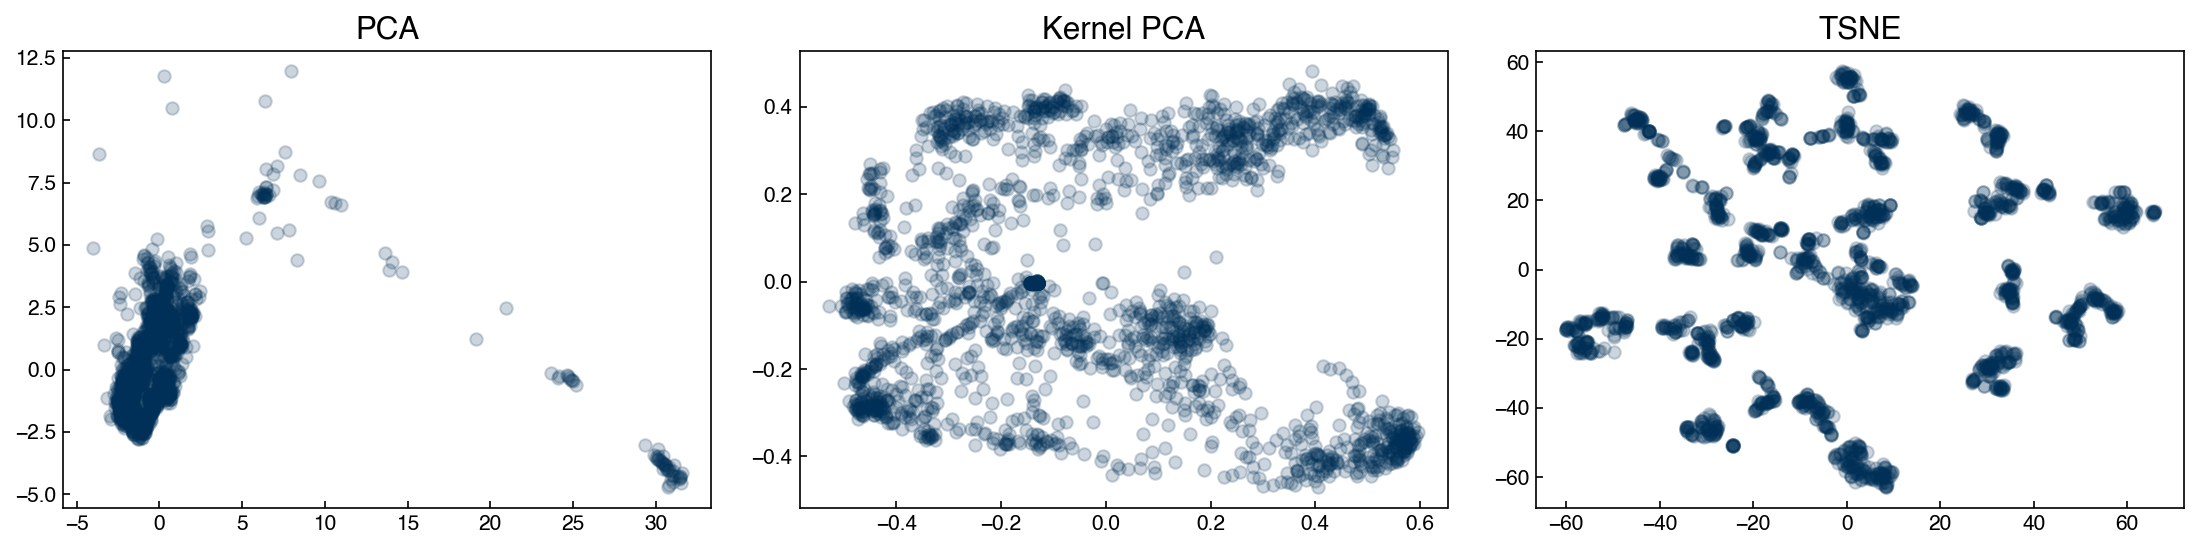

In [6]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4))
data = [X_pca, X_kpca, X_tsne]
labels = ['PCA', 'Kernel PCA', 'TSNE']
for X_i, label, ax in zip(data, labels, axes):
    ax.scatter(X_i[:, 0], X_i[:, 1], alpha = 0.2)
    ax.set_title(label)
    
plt.tight_layout()

We can see that the structure of the low-dimensional representations depends on the technique we use. We will use these datasets as examples for various types of clustering models to see how we might end up with different "clusters" of chemical process parameters depending on the dimensional reduction and clustering technique we use.

In a real scenario, we would want to go back to the original data and process parameters to see if these clusters align with our intuition as engineers. For example, clusters might represent different steady-states or set-points for the process.

## Expectation-maximization models

### k-means

The k-means algorithm is the simplest and most intuitive clustering algorithm. It performs remarkably well under a number of assumptions:

* Number of clusters are known
* Clusters are roughly spherical
* Clusters are separated by linear boundaries

Even if these assumptions are violated, it often works anyway, especially in high dimensions (the "blessing" of dimensionality).

The k-means algorithm works using the principal of **expectation-maximization**. This is an iterative type of algorithm that contains two basic steps:

* Expectation: Assign points based on some "expectation" metric.
* Maximization: Revise expectations based on maximizing a fitness metric.

In the case of k-means we:

* Expect that points close to the center of a cluster belong to that cluster
* Maximize the proximity of points to the center of a cluster by moving the center

This process is iterated until convergence.

We will create a simple "toy" implementation of k-means, and see how it works for the Dow dataset.

In [7]:
def dist(pt1, pt2):
    # Euclidean distance between two points
    # Note that this can also be performed with np.linalg.norm(pt1-pt2)
    return np.sqrt(sum([(xi - yi)**2 for xi, yi in zip(pt1, pt2)]))

def expected_assignment(pt, cluster_centers):
    # Expectation: find the closest points to each cluster center
    dists = [dist(pt, ci) for ci in cluster_centers] #<- find distance to each center
    min_index = dists.index(min(dists)) #<- find the index (cluster) with the minimum dist
    return min_index

def new_centers(cluster_points, centers):
    # Maximization: maximize the proximity of centers to points in a cluster
    centers = list(centers)
    for i, ci in enumerate(cluster_points):
        if ci != []:
            centers[i] = np.mean(ci, axis = 0)
    return centers

Now we need an "initial guess" of cluster centers and we can apply the algorithm to a toy dataset:

(2060, 2)


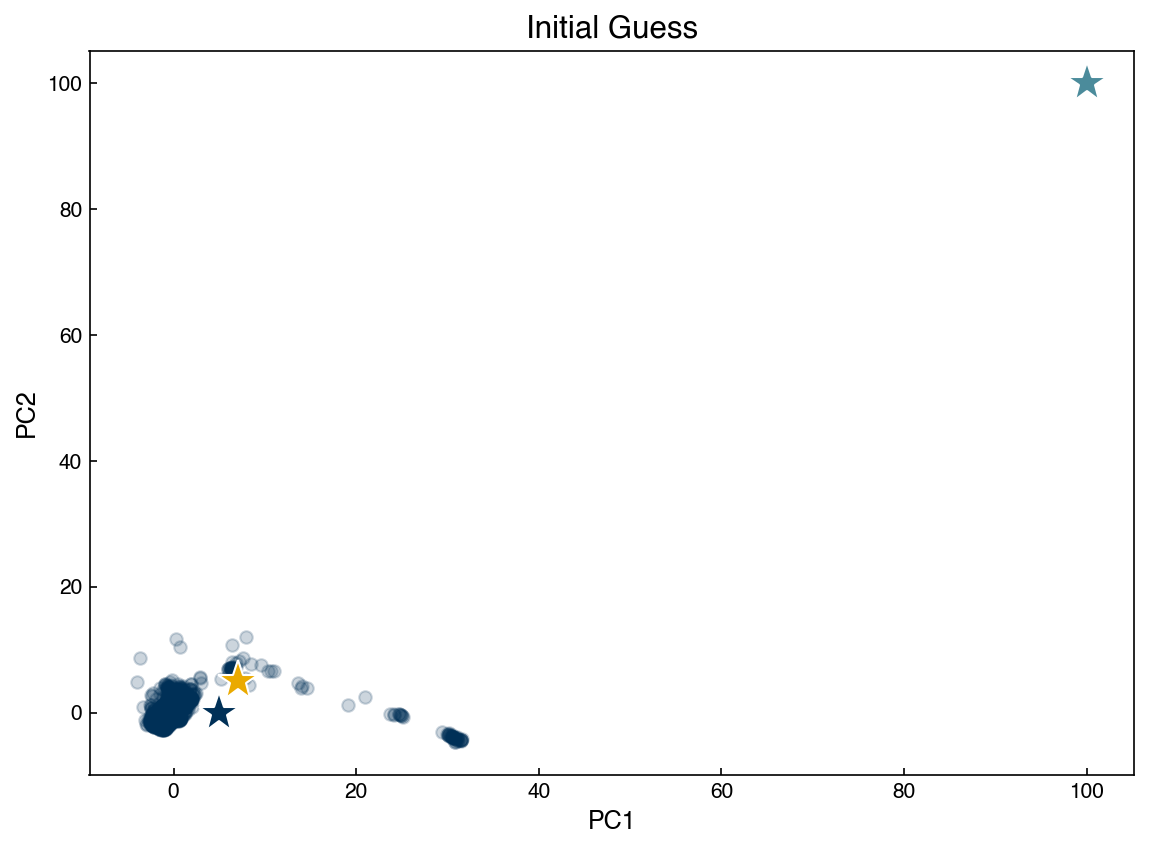

In [8]:
X = X_pca
print(X.shape)

#cluster_centers = ([-0.5,0], [0.5,0])
cluster_centers = ([5, 0], [7, 5], [100, 100])
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], alpha = 0.2)
for i, ci in enumerate(cluster_centers):
    ax.plot(ci[0], ci[1], marker = '*', markersize = '20', color=clrs[i], mec = 'w')
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Initial Guess');

Run the cell below repeatedly to see how the algorithm converges. Re-run the cell above to re-start the algorithm.

[-0.88397179 -0.09374578]
[17.88903744  1.89714391]
[100, 100]


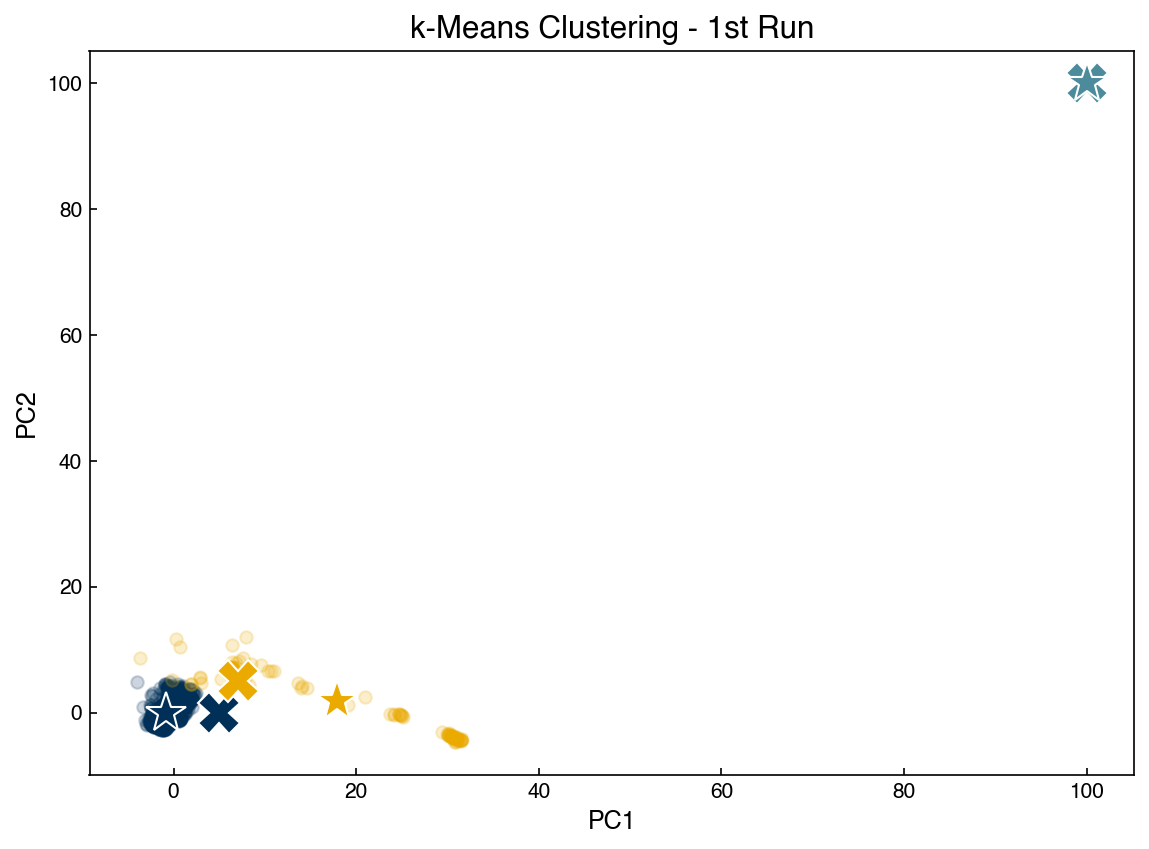

In [9]:
fig, ax = plt.subplots()

old_centers = cluster_centers

# Which cluster do we "expect" each point to belong to?
clusters = [[], [], [], []]
for pt in X:
    cluster_idx = expected_assignment(pt, cluster_centers)
    clusters[cluster_idx].append(pt)
    
# What centers best represent these new assignments?
cluster_centers = new_centers(clusters, cluster_centers)

# Plot new assignments
for i, ci in enumerate(clusters):
    for pt in ci:
        ax.plot(pt[0], pt[1], marker = 'o', color = clrs[i], alpha = 0.2)

# Plot old centers
for i, ci in enumerate(old_centers):
    ax.plot(ci[0], ci[1], marker = 'X', markersize = '20', color = clrs[i], markeredgecolor = 'w')

# Plot new centers
for i, ci in enumerate(cluster_centers):
    print(ci)
    ax.plot(ci[0], ci[1], marker = '*', markersize = '20', color = clrs[i], mec = 'w')
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('k-Means Clustering - 1st Run');

[-0.77233592  0.03861822]
[25.74453066 -1.28727407]
[100, 100]


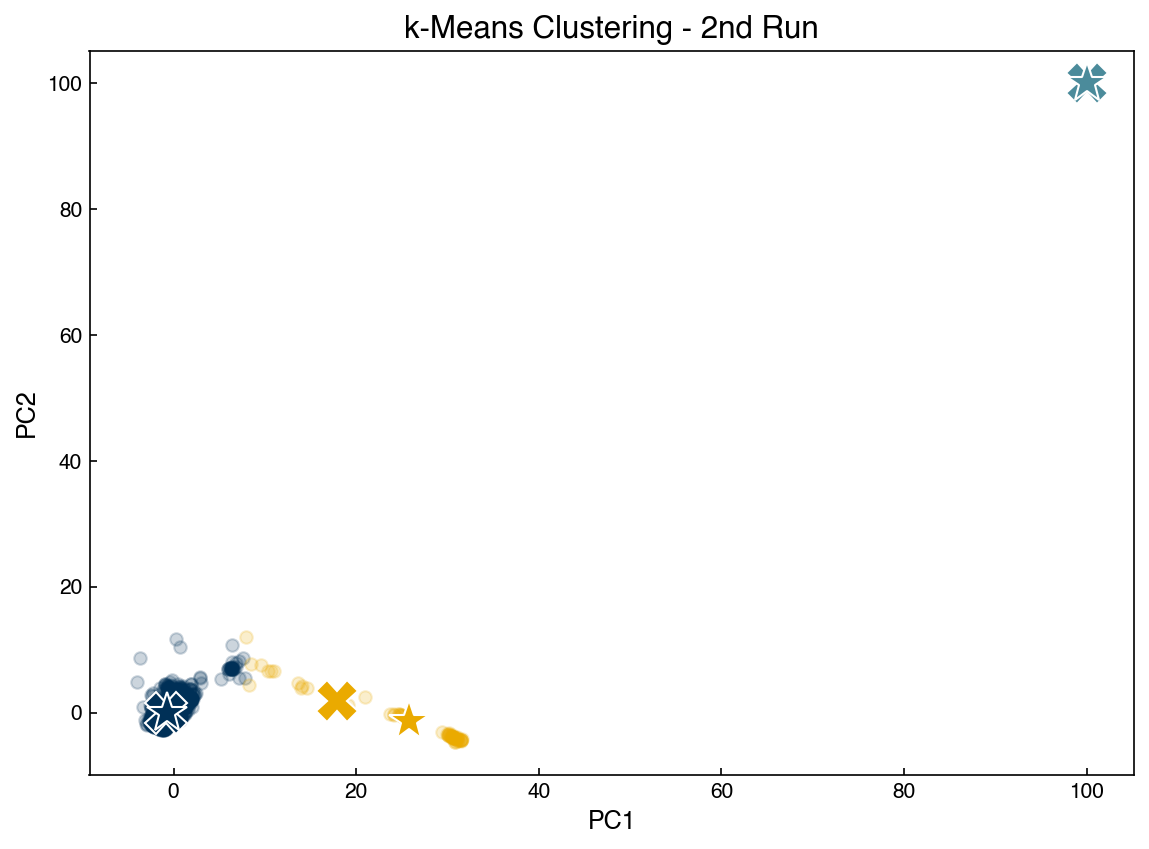

In [10]:
fig, ax = plt.subplots()

old_centers = cluster_centers
    
clusters = [[], [], [], []]
for pt in X:
    cluster_idx = expected_assignment(pt, cluster_centers)
    clusters[cluster_idx].append(pt)
    
cluster_centers = new_centers(clusters, cluster_centers)

for i, ci in enumerate(clusters):
    for pt in ci:
        ax.plot(pt[0], pt[1], marker = 'o', color = clrs[i], alpha = 0.2)
        
for i, ci in enumerate(old_centers):
    ax.plot(ci[0], ci[1], marker = 'X', markersize = '20', color = clrs[i], mec = 'w')
    
for i, ci in enumerate(cluster_centers):
    print(ci)
    ax.plot(ci[0], ci[1], marker = '*', markersize = '20', color = clrs[i], mec = 'w')
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('k-Means Clustering - 2nd Run');

[-0.73658236  0.06425897]
[27.89284524 -2.43335379]
[100, 100]


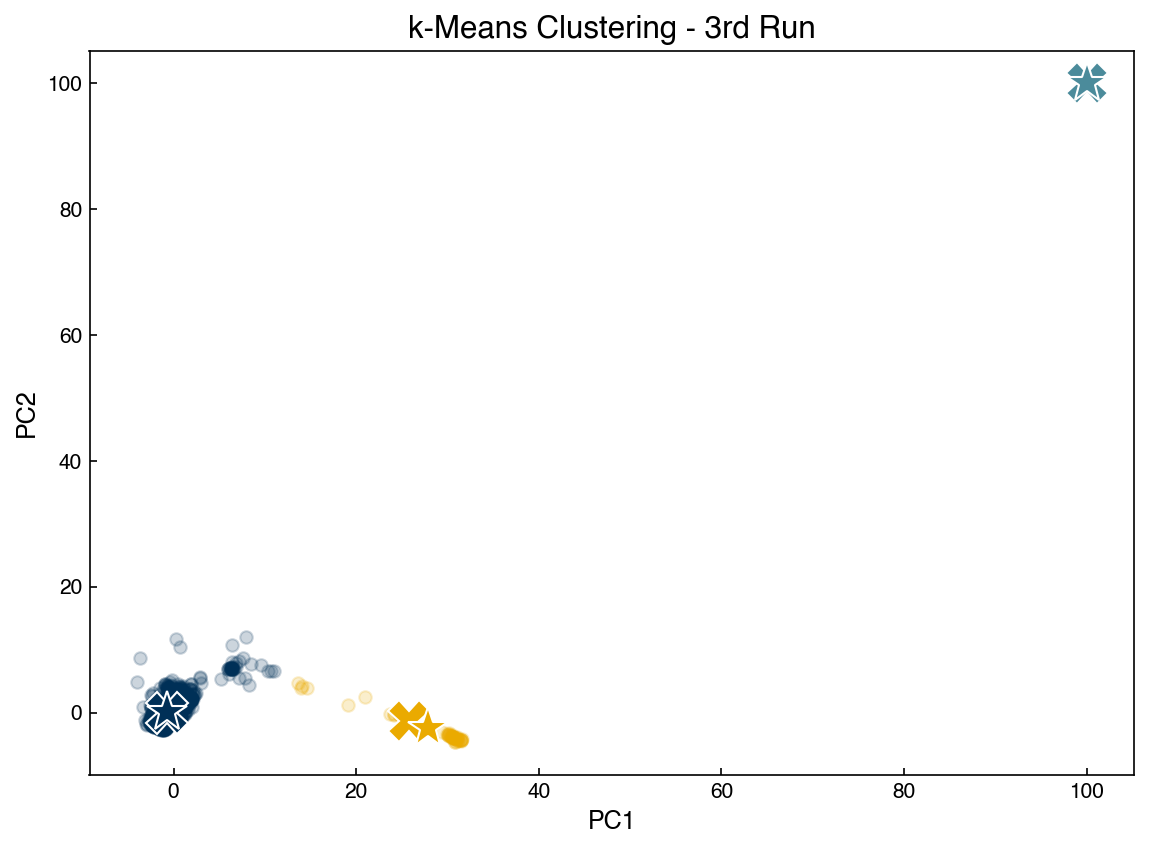

In [11]:
fig, ax = plt.subplots()

old_centers = cluster_centers
    
clusters = [[], [], [], []]
for pt in X:
    cluster_idx = expected_assignment(pt, cluster_centers)
    clusters[cluster_idx].append(pt)
    
cluster_centers = new_centers(clusters, cluster_centers)

for i, ci in enumerate(clusters):
    for pt in ci:
        ax.plot(pt[0], pt[1], marker = 'o', color = clrs[i], alpha = 0.2)
        
for i, ci in enumerate(old_centers):
    ax.plot(ci[0], ci[1], marker = 'X', markersize = '20', color = clrs[i], mec = 'w')
    
for i, ci in enumerate(cluster_centers):
    print(ci)
    ax.plot(ci[0], ci[1], marker = '*', markersize = '20', color = clrs[i], mec = 'w')
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('k-Means Clustering - 3rd Run');

In practice it is more efficient to utilize the `scikit-learn` implementation of `KMeans`:

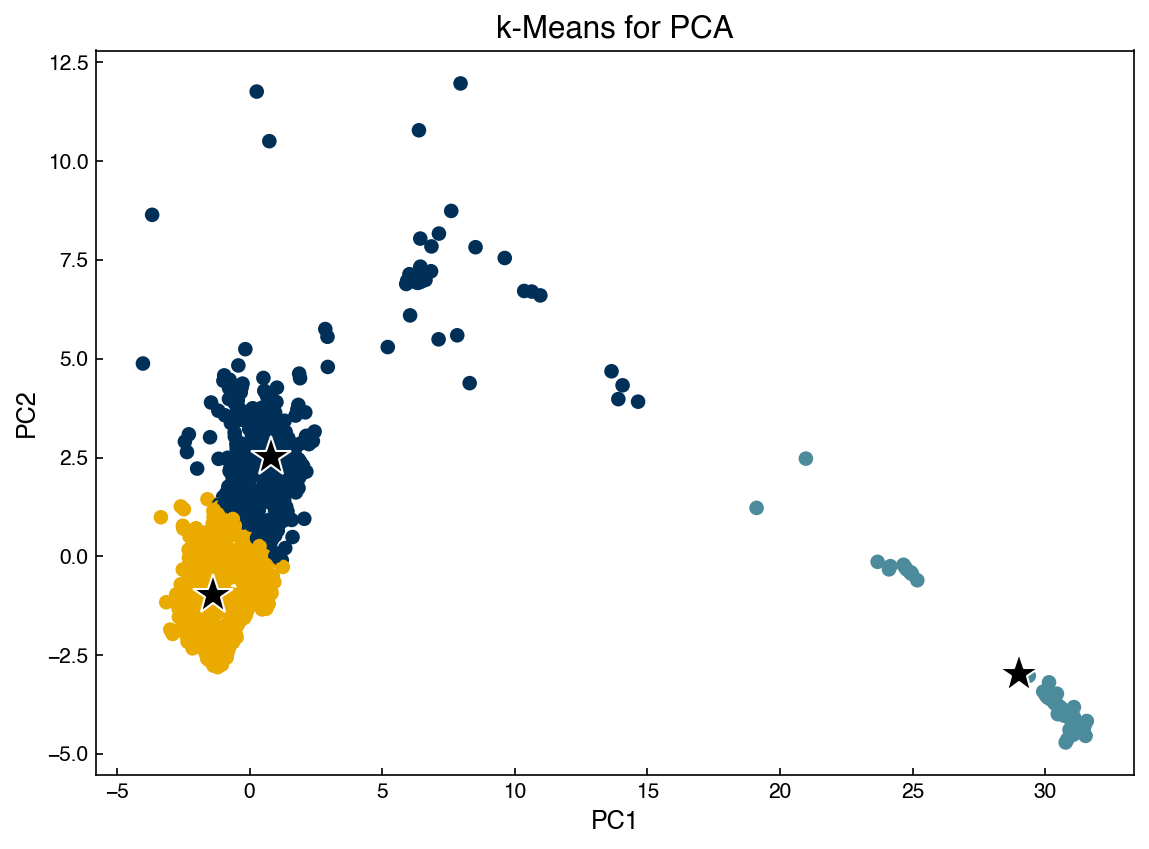

In [13]:
from sklearn.cluster import KMeans

n_clusters = 3
random_state = 20
X = X_pca #scikit-learn is much more efficient, so we can run it on the whole datset

model = KMeans(n_clusters = n_clusters)#, random_state=random_state)
model.fit(X)
y_predict = model.predict(X)
centers = model.cluster_centers_

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c = clrs[y_predict])
for center in centers:
    x_i = center[0]
    y_i = center[1]
    ax.plot(x_i, y_i, marker = '*', color = 'k', mec = 'w', markersize = 20)
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('k-Means for PCA');

We can apply the same algorithm to other dimensional reduction techniques:

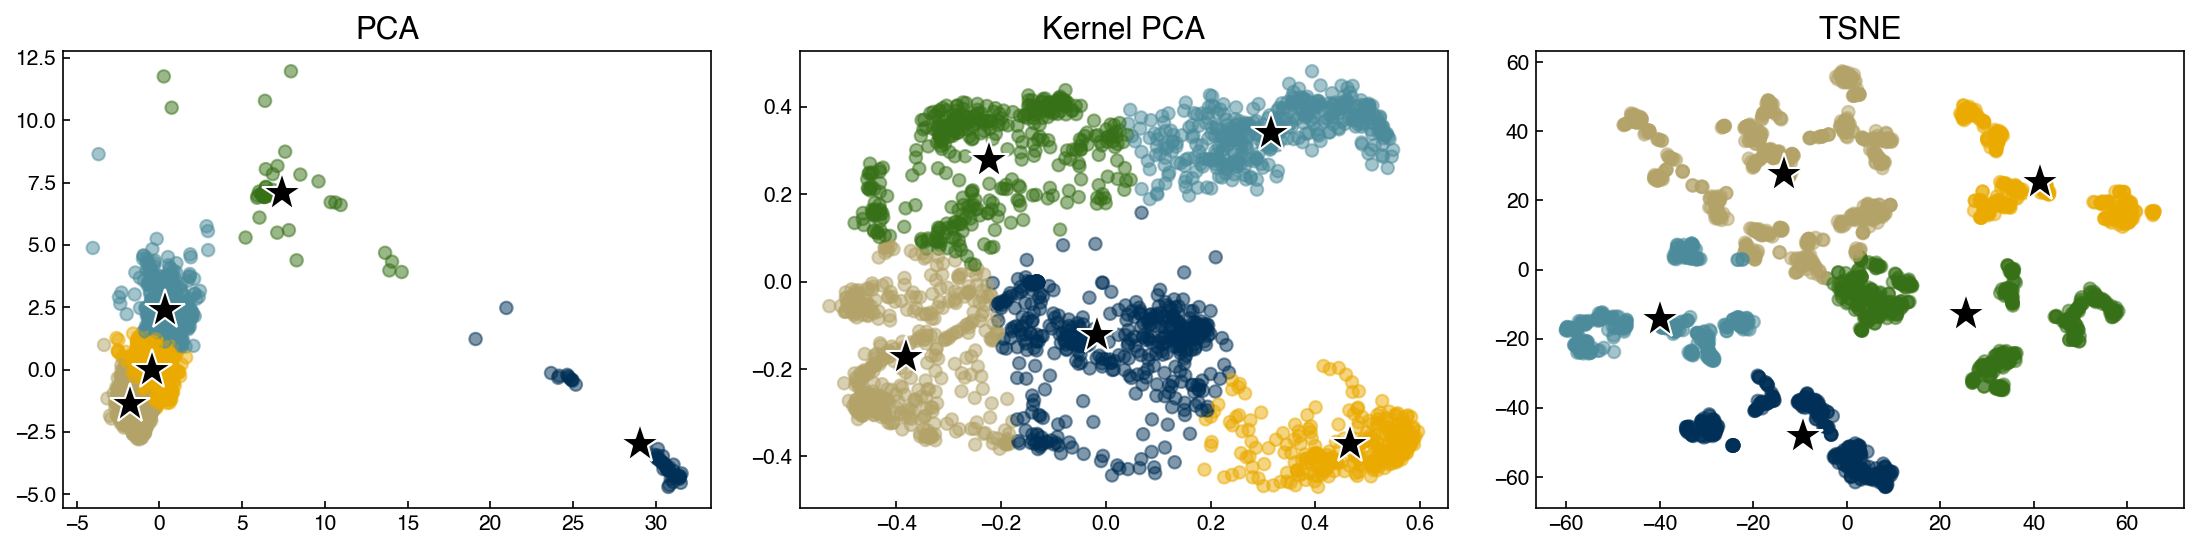

In [14]:
data = [X_pca, X_kpca, X_tsne]
labels = ['PCA', 'Kernel PCA', 'TSNE']
fig, axes = plt.subplots(1, 3, figsize = (15,4))

n_clusters = 5
random_state = 0

for X_i, label, ax in zip(data, labels, axes):
    model = KMeans(n_clusters = n_clusters, random_state = random_state)
    model.fit(X_i)
    y_predict = model.predict(X_i)
    centers = model.cluster_centers_
    ax.scatter(X_i[:, 0], X_i[:, 1], c = clrs[y_predict], alpha = 0.5)
    for center in centers:
        x_i = center[0]
        y_i = center[1]
        ax.plot(x_i, y_i, marker = '*', color = 'k', mec = 'w', markersize = 20)
        ax.set_title(label)

### Discussion: Which of these clusters might be outliers?

> The navy-colored cluster on the PCA plot could be an outlier. It has different patterns as compared to other clusters, but we cannot ensure whether they are actual outliers. To check this, it is good to go back and look the original data. Moreover, some other outliers can be identified from Kernel PCA and TSNE if you increase `n_clusters` to a bigger number.

### Gaussian mixture models

Gaussian mixture models, or GMM's, are another clustering approach based on expectation maximization. The approach is to model each cluster as a Gaussian distribution, and to model the entire dataset as a mixture of Gaussians. Mathematically:

$ P(\vec{x}) = \sum_k \phi_k \mathcal{N}(\vec{x}, \vec{\mu}, \vec{\sigma})$

where $\mathcal{N}$ is the normal distribution:

* one dimension: $N(x, \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left( \frac{-(x-\mu)^2}{2 \sigma ^2} \right)$

* multi-dimensional: $N(\vec{x}, \vec{\mu}, \underline{\underline{\Sigma}}) = \frac{1}{(2 \pi |\underline{\underline{\Sigma}}|)} \exp \left( \frac{1}{2} (\vec{x} - \vec{\mu})^T \underline{\underline{\Sigma}}^{-1}  (\vec{x} - \vec{\mu}) \right)$

where $\underline{\underline{\Sigma}}$ is the covariance matrix.

#### Expectation step:

We can calculate the expected probability that a point $i$ is in a cluster $k$ with the following formula for a 1D Gaussian:

$\gamma_{ik} = \frac{\phi_k \mathcal{N}(\vec{x}_i, \vec{\mu}_k, \vec{\sigma}_k)}{\sum_j \phi_j \mathcal{N}(\vec{x}_i, \vec{\mu}_j, \vec{\sigma}_j)}$

#### Maximization step:

The parameters of the distributions can then be updated by calculating the maximum likelihood estimators for $\phi$, $\mu$, and $\sigma$, similar to the way these parameters would be estimated for a single distribution:

* $\phi_k = \sum_{i=1}^N \frac{\gamma_{ik}}{N}$
* $\mu_k = \frac{\sum_{i=1}^N \gamma_{ik} x_i}{\sum_{i=1}^N \gamma_{ik}} $
* $\sigma_k = \frac{\sum_{i=1}^N \gamma_{ik} (x_i - \mu_k)^2}{\sum_{i=1}^N \gamma_{ik}} $

These parameters are derived by maximizing $P(\vec{x})$ with respect to each parameter. The formulas for multi-dimensional Gaussians are derived in the same way but are more complex.

```{image} ./GMM.gif
:width: 500px
```

Gaussian mixture models are much more flexible than k-means models because they have different variances and covariances between clusters. Let's see how GMM's perform for some of the earlier datasets:

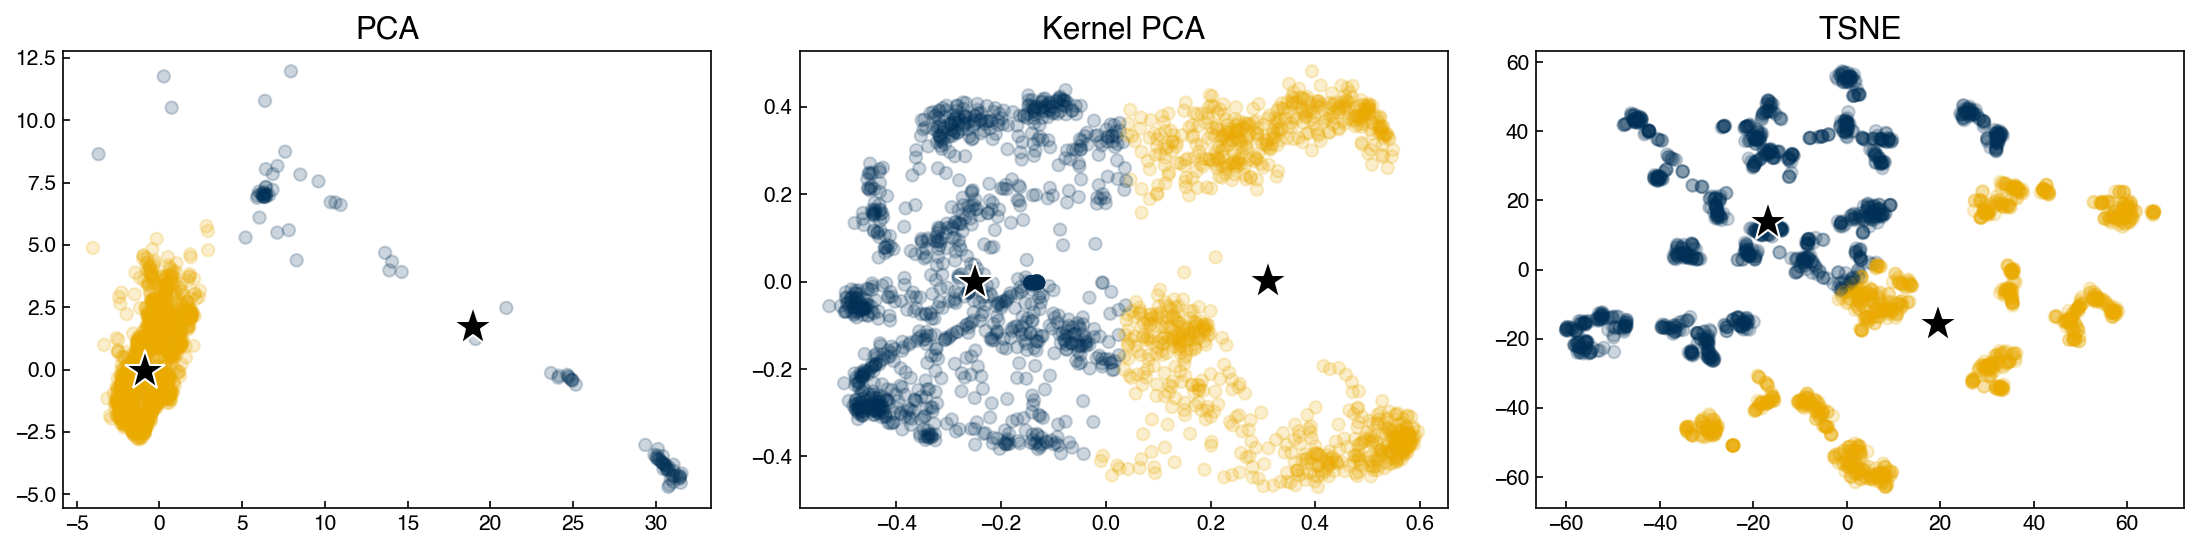

In [15]:
from sklearn.mixture import GaussianMixture

n_clusters = 2
random_state = 0
covariance_type = 'full' #full, tied, spherical

fig, axes = plt.subplots(1, 3, figsize = (15, 4))

for X_i, label, ax in zip(data, labels, axes):
    model = GaussianMixture(n_components = n_clusters, random_state = random_state, covariance_type = covariance_type)
    model.fit(X_i)
    y_predict = model.predict(X_i)
    centers = model.means_
    ax.scatter(X_i[:, 0], X_i[:, 1], c = clrs[y_predict], alpha=0.2)
    for center in centers:
        x_i = center[0]
        y_i = center[1]
        ax.plot(x_i, y_i, marker = '*', color = 'k', mec = 'w', markersize = 20)
        ax.set_title(label)

Note that we set the covariance type to `full`. This means that all entries in the covariance matrix are optimized during the "maximization" step. Selecting "tied" means that only the diagonal elements of the covariance matrix will be non-zero, and selecting "spherical" means that only diagonal elements will be non-zero and they will all be equal. Using `full` provides the most parameters to optimize, but also takes the longest and is most sensitive to initial guesses. Using `spherical` is very similar to k-means.

GMM's have the same weakness as k-means since we need to know the number of clusters beforehand. One way to be more quantitative is to assess a metric such as the Silhouette score as a function of number of clusters.

In [16]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

X_i = X_pca
n_clusters = 10

model = GaussianMixture(n_components = n_clusters, random_state = random_state, covariance_type = covariance_type)
model.fit(X_i)
y_predict = model.predict(X_i)

silhouette = silhouette_score(X_i, y_predict)
c_h_score = calinski_harabasz_score(X_i, y_predict)

print(silhouette)
print(c_h_score)

0.3889340481198901
5375.873303272862


### Example: Plot the silhouette score as a function of number of clusters for a GMM model on the PCA dataset

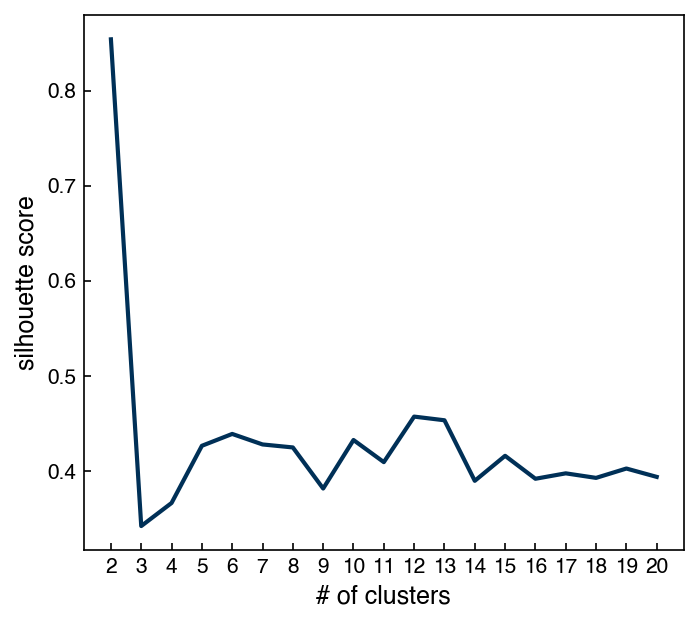

In [17]:
n_clusters_list = np.arange(2, 21, 1)

silhouette_list = []
for n in n_clusters_list:
    m = GaussianMixture(n_components = n)
    m.fit(X_i)
    predict = m.predict(X_i)
    
    silhouette = silhouette_score(X_i, predict)
    silhouette_list.append(silhouette)
    
fig, ax = plt.subplots(figsize = (5, 4.5), dpi = 150)
ax.plot(n_clusters_list, silhouette_list, '-')
ax.set_xlabel('# of clusters')
ax.set_ylabel('silhouette score')
ax.set_xticks(n_clusters_list);

One additional difference between GMM's and k-means is that GMM's support "mixed membership". GMM's assign points to clusters by selecting the cluster that a point has the highest probability of belonging to. However, we can also check the probabilities for all clusters:

In [18]:
probabilities = model.predict_proba(X_i)
clusters = model.predict(X_i)
print("Probabilities shape: {}".format(probabilities.shape))
print("Clusters shape: {}".format(clusters.shape))
print((probabilities[0, :], clusters[0]))

Probabilities shape: (2060, 10)
Clusters shape: (2060,)
(array([0.00000000e+00, 1.59901044e-01, 1.85204790e-05, 8.73882805e-82,
       0.00000000e+00, 7.90943391e-08, 0.00000000e+00, 8.35967386e-01,
       2.87052747e-32, 4.11297046e-03]), 7)


We can see that the predicted cluster is the one with the highest probability:

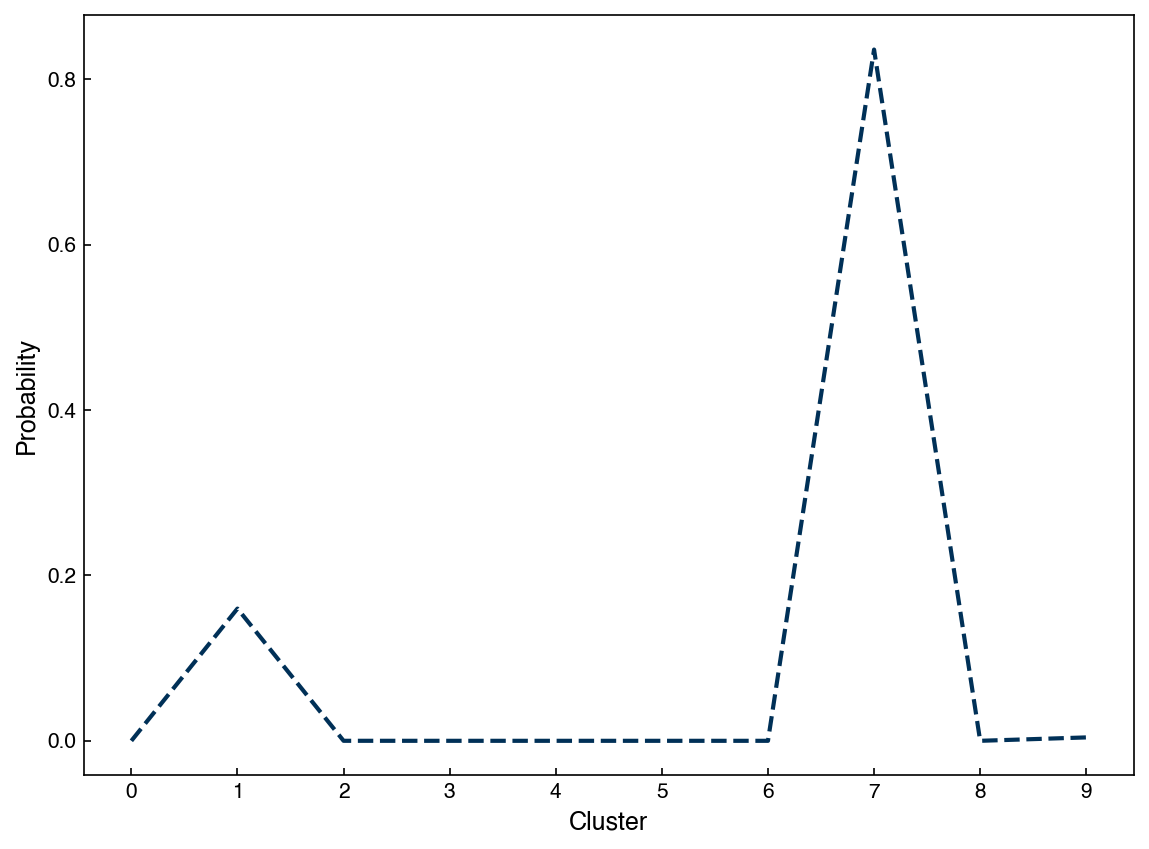

In [19]:
fig, ax = plt.subplots()

point_idx = 0
ax.plot(range(0, n_clusters), probabilities[point_idx, :])
#ax.plot([clusters[point_idx], clusters[point_idx]], [0, 1])
ax.set_xlabel('Cluster')
ax.set_ylabel('Probability')
ax.set_xticks(range(10));

However, there is also a non-zero probability that the point is in other clusters (cluster number 7 in this case). We can use this to figure out which points are well-clustered and which ones are not:

(660, 2)


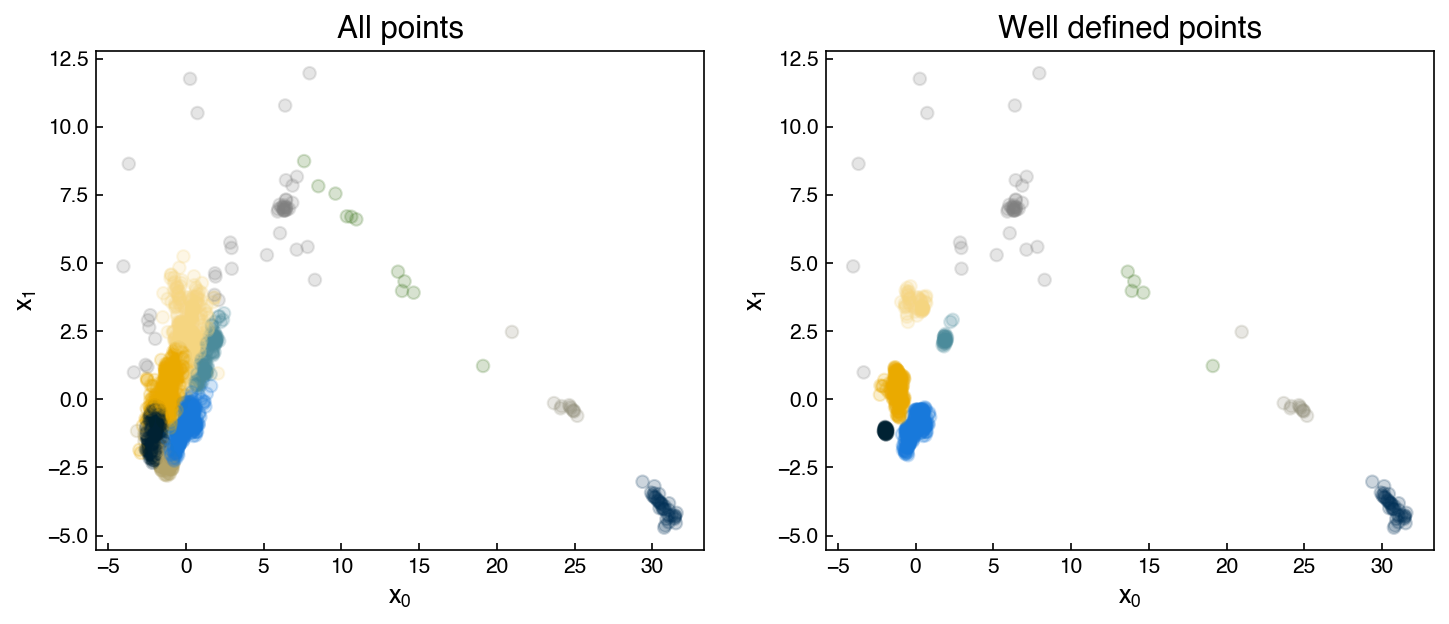

In [20]:
well_defined = []
for point in X_i:
    point = point.reshape(1, -1)
    probs = model.predict_proba(point)
    if probs.max() > 0.95:
        well_defined.append(point.ravel())

X_welldefined = np.array(well_defined)
print(X_welldefined.shape)
y_welldefined = model.predict(X_welldefined)

fig, axes = plt.subplots(1, 2, figsize = (10, 4.5))

axes[0].scatter(X_i[:, 0], X_i[:, 1], c = clrs[y_predict], alpha = 0.2)
axes[0].set_title('All points')
axes[1].scatter(X_welldefined[:,0], X_welldefined[:,1], c = clrs[y_welldefined], alpha = 0.2)
axes[1].set_title('Well defined points')

for ax in axes:
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')

Of course, the silhoutte scores should be much higher for these "well defined" clusters:

In [21]:
silhouette = silhouette_score(X_i, y_predict)
silhouette_welldefined = silhouette_score(X_welldefined, y_welldefined)
print("Silhouette score for all points: {}".format(silhouette))
print("Silhouette score for well-defined points: {}".format(silhouette_welldefined))

Silhouette score for all points: 0.3889340481198901
Silhouette score for well-defined points: 0.6344883005388762


Another advantage of GMM's is that they have some built-in statistical measures. For example, we can compute the Bayesian information critera for the model:

In [22]:
print(model.bic(X_i))

12428.380003864966


We will cover more details of the BIC and other advanced features of GMM's when we discuss generative models.

## Density-based models

Density-based clustering algorithms consider local density of points and utilize this information to group points into clusters.

### Mean shift algorithm

The simplest density-based algorithm is the "mean shift" algorithm. This is similar to k-means in that we seek the centroid of each cluster. The difference is that in mean shift the number of clusters does not need to be specified. Instead a "window" is specified, and at each iteration the centroids are updated to centroid of all points in each window. Let's see how this works for a single point:

In [23]:
def get_distance(x1, x2):
    # we will use the numpy 2-norm to calculate Euclidean distance:
    return np.linalg.norm(x1-x2, 2) #<- the 2 is optional here since 2 is the default.

def get_nearby_points(x, x_list, r):
    # r is the radius
    dist_pairs = []
    for i,xi in enumerate(x_list):
        dist = get_distance(x, xi)
        dist_pairs.append([dist, i, xi]) #<- gives us the distance for each point
    in_window = [pt[-1] for pt in dist_pairs if pt[0] <= r]
    return in_window

def get_new_centroid(old_centroid, x_list, r):
    in_range = get_nearby_points(old_centroid, x_list, r)
    if len(in_range) == 0:
        new_centroid = old_centroid
    else:
        new_centroid = np.array(in_range).mean(axis = 0)
    return new_centroid

Note the similarity to the kNN functions for prior lectures. It is a good idea to "abstract out" the distance function so that we could try other distance metrics easily.

Let's apply this to a single point in a dataset:

In [24]:
guess = [5, 0] #<- set an initial guess

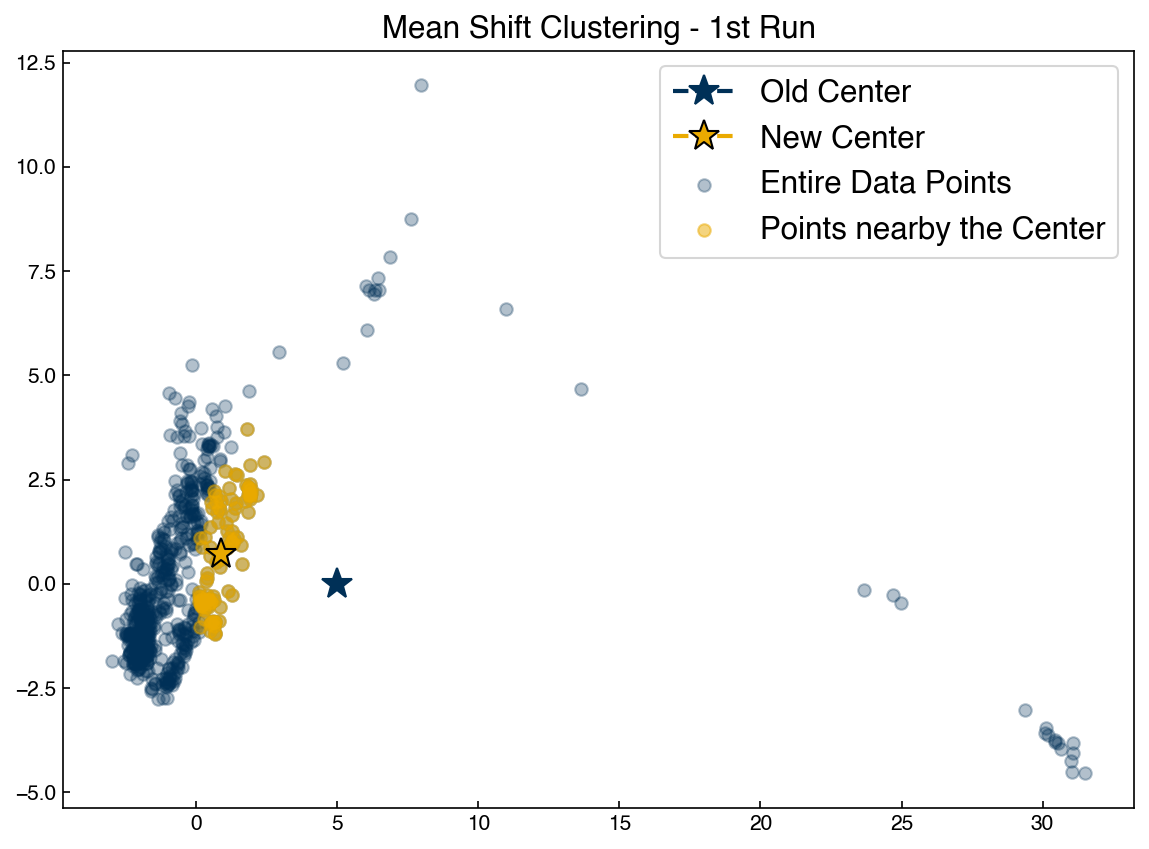

In [25]:
X = X_pca[::3] #take every third point to speed things up
r = 5

nearby = get_nearby_points(guess, X, r)
nearby = np.array(nearby)
new = get_new_centroid(guess, X, r)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], color = clrs[0], alpha = 0.3)
ax.scatter(nearby[:, 0], nearby[:, 1], color = clrs[1], alpha = 0.5)
ax.plot(guess[0], guess[1], marker = '*', color = clrs[0], markersize = 15)
ax.plot(new[0], new[1], marker='*', color = clrs[1], markersize = 15, mec = 'k')

ax.set_title('Mean Shift Clustering - 1st Run')
ax.legend(['Old Center', 'New Center', 'Entire Data Points', 'Points nearby the Center'])

guess = new

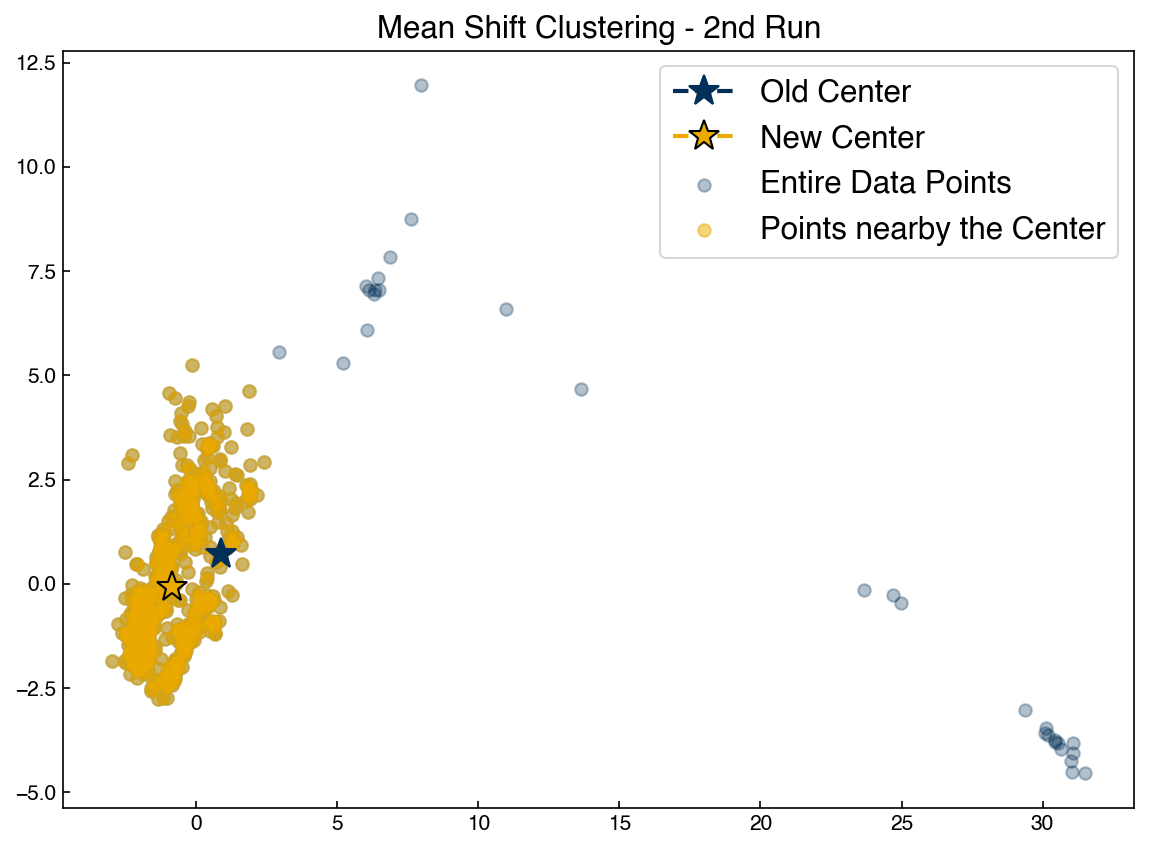

In [26]:
nearby = get_nearby_points(guess, X, r)
nearby = np.array(nearby)
new = get_new_centroid(guess, X, r)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], color = clrs[0], alpha = 0.3)
ax.scatter(nearby[:, 0], nearby[:, 1], color = clrs[1], alpha = 0.5)
ax.plot(guess[0], guess[1], marker = '*', color = clrs[0], markersize = 15)
ax.plot(new[0], new[1], marker='*', color = clrs[1], markersize = 15, mec = 'k')

ax.set_title('Mean Shift Clustering - 2nd Run')
ax.legend(['Old Center', 'New Center', 'Entire Data Points', 'Points nearby the Center'])

guess = new

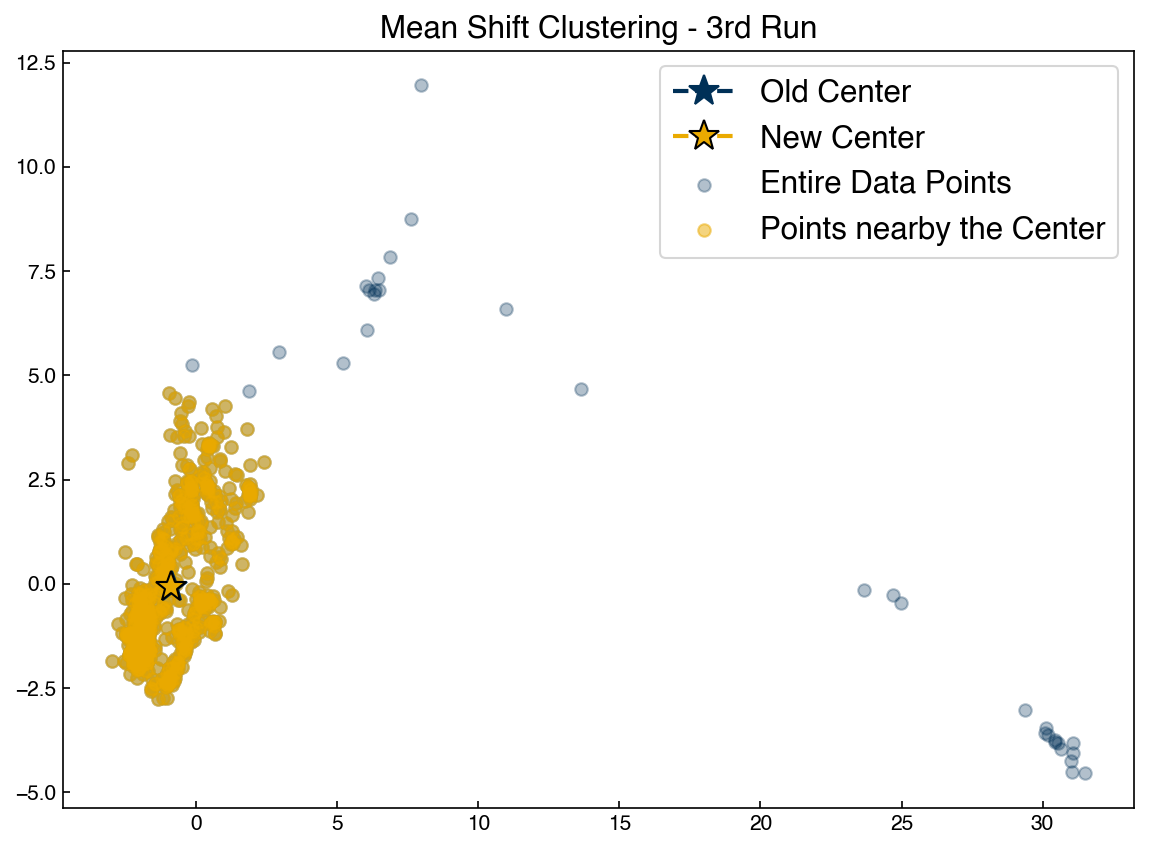

In [27]:
nearby = get_nearby_points(guess, X, r)
nearby = np.array(nearby)
new = get_new_centroid(guess, X, r)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], color = clrs[0], alpha = 0.3)
ax.scatter(nearby[:, 0], nearby[:, 1], color = clrs[1], alpha = 0.5)
ax.plot(guess[0], guess[1], marker = '*', color = clrs[0], markersize = 15)
ax.plot(new[0], new[1], marker='*', color = clrs[1], markersize = 15, mec = 'k')

ax.set_title('Mean Shift Clustering - 3rd Run')
ax.legend(['Old Center', 'New Center', 'Entire Data Points', 'Points nearby the Center'])

guess = new

Re-run the block above to watch the point converge. You can play with the initial guess to see how it changes things.

### Discussion: What happens if the initial guess is very far away from a cluster?

> There will be no points within the radius (or `bandwidth`) and this algorithm is not going to work. Change the initial guess to [10, 0] and rerun the algorithm. You will notice that the `nearby` list is empty.

We see that the mean shift algorithm causes an initial guess for a centroid to move toward a point of higher density. However, it isn't clear exactly how to get initial guesses. If we choose random points then some will have no points around them and not move. It also isn't clear how to decide how many initial guess points we should use.

The solution to this is to use each point of the dataset as an initial guess!

In [28]:
centroids = X

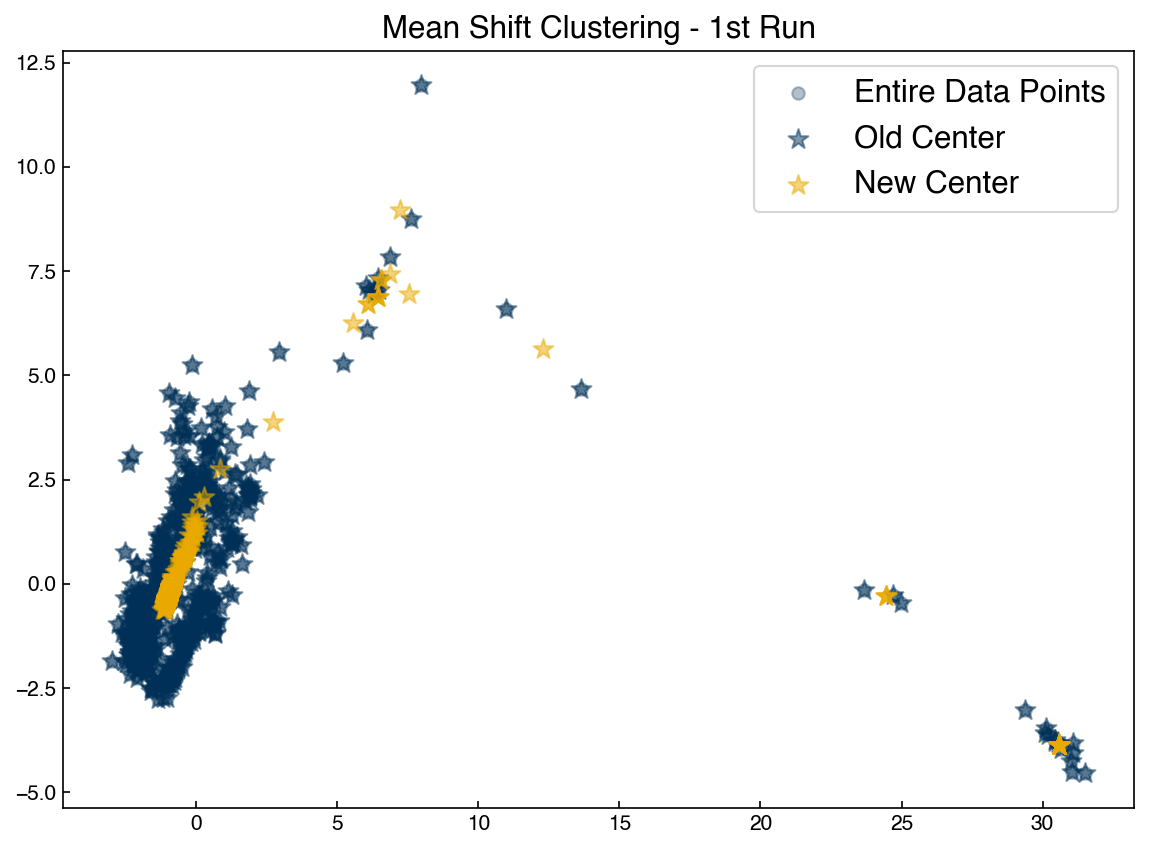

In [29]:
def mean_shift_iteration(x_list, r):
    centroids = []
    for centroid in x_list:
        new = get_new_centroid(centroid, x_list, r)
        centroids.append(new)
    return centroids

new_centroids = mean_shift_iteration(centroids, r)

news = np.array(new_centroids)
olds = np.array(centroids)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], color = clrs[0], alpha = 0.3)
ax.scatter(olds[:, 0], olds[:, 1], color = clrs[0], marker = '*', alpha = 0.5, s = 100)
ax.scatter(news[:, 0], news[:, 1], color = clrs[1], marker = '*', alpha = 0.5, s = 100)

ax.set_title('Mean Shift Clustering - 1st Run')
ax.legend(['Entire Data Points', 'Old Center', 'New Center'])

centroids = new_centroids

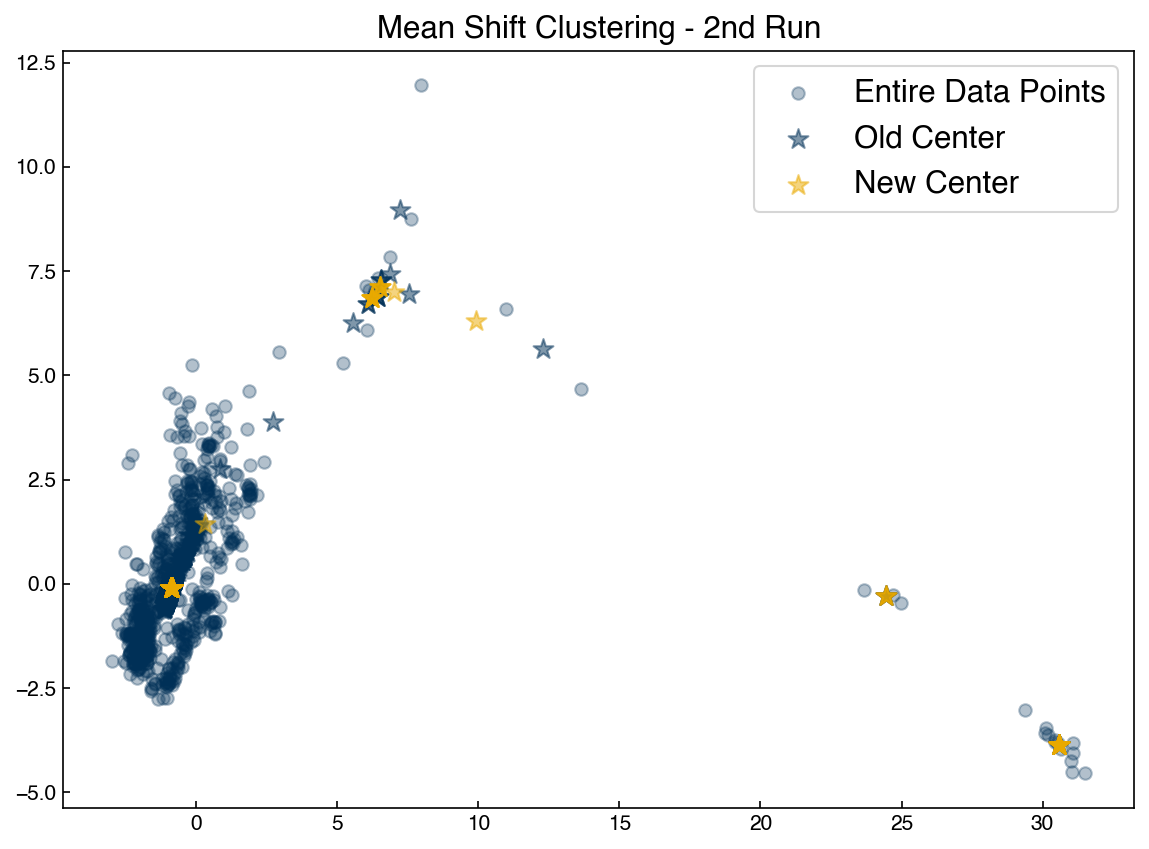

In [30]:
new_centroids = mean_shift_iteration(centroids, r)

news = np.array(new_centroids)
olds = np.array(centroids)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], color = clrs[0], alpha = 0.3)
ax.scatter(olds[:, 0], olds[:, 1], color = clrs[0], marker = '*', alpha = 0.5, s = 100)
ax.scatter(news[:, 0], news[:, 1], color = clrs[1], marker = '*', alpha = 0.5, s = 100)

ax.set_title('Mean Shift Clustering - 2nd Run')
ax.legend(['Entire Data Points', 'Old Center', 'New Center'])

centroids = new_centroids

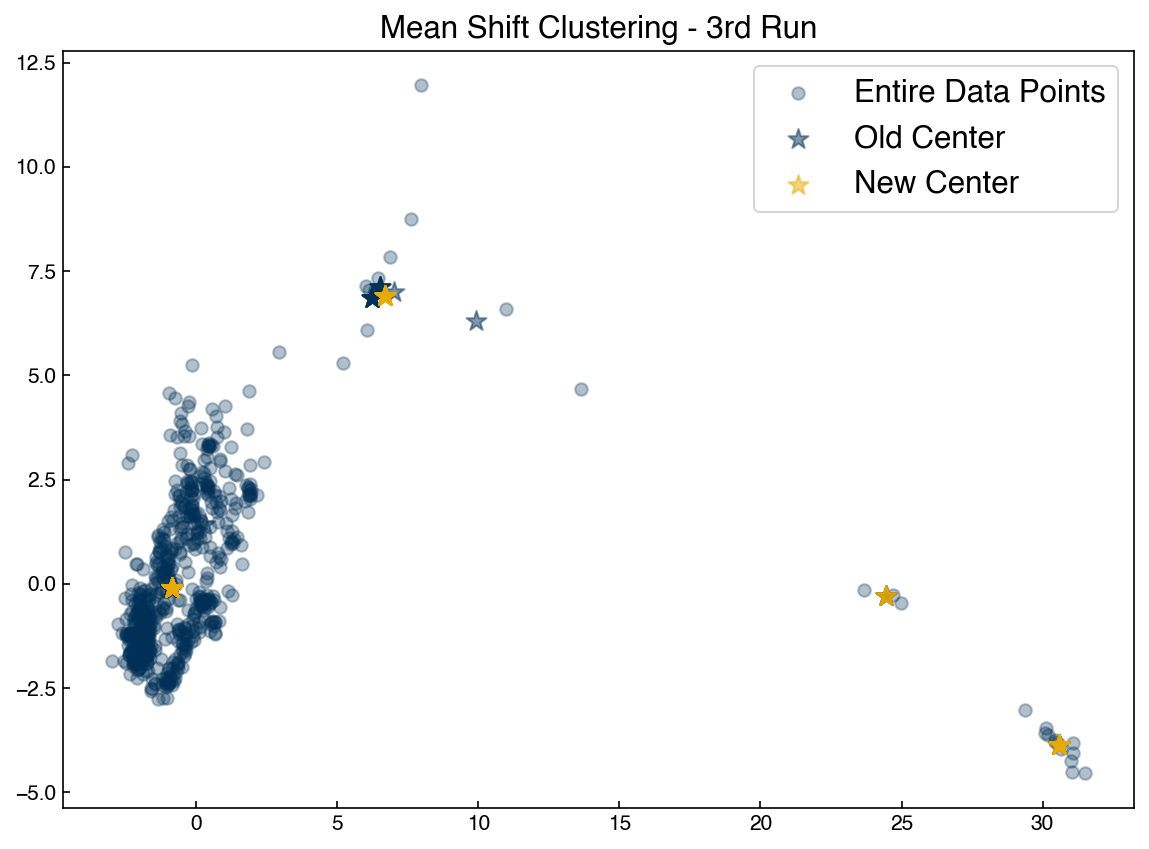

In [31]:
new_centroids = mean_shift_iteration(centroids, r)

news = np.array(new_centroids)
olds = np.array(centroids)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], color = clrs[0], alpha = 0.3)
ax.scatter(olds[:, 0], olds[:, 1], color = clrs[0], marker = '*', alpha = 0.5, s = 100)
ax.scatter(news[:, 0], news[:, 1], color = clrs[1], marker = '*', alpha = 0.5, s = 100)

ax.set_title('Mean Shift Clustering - 3rd Run')
ax.legend(['Entire Data Points', 'Old Center', 'New Center'])

centroids = new_centroids

To complete the algorithm we just need to iterate until the new centrods are the same as the old centroids, and assign points to the nearest centroid:

Working: delta = 137.41
Working: delta = 65.42
Working: delta = 4.03
CPU times: user 13.6 s, sys: 83 ms, total: 13.7 s
Wall time: 13.7 s


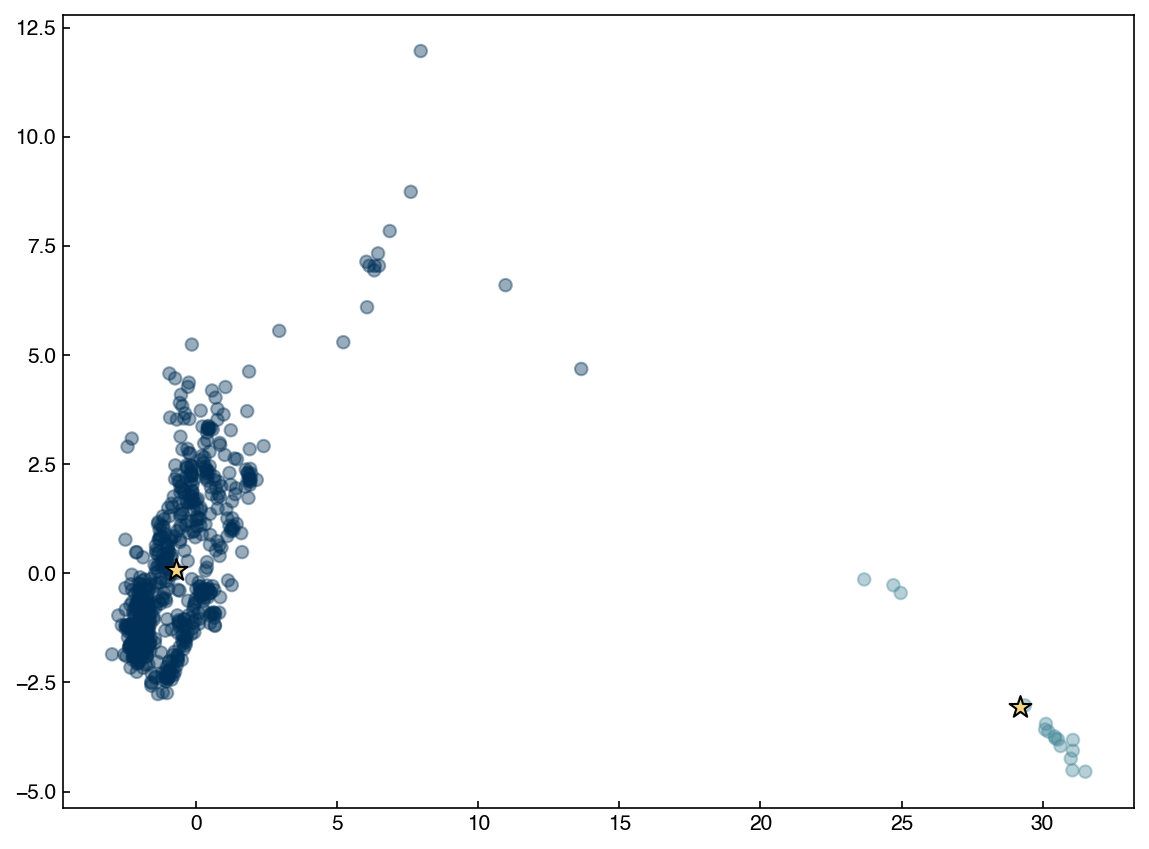

In [32]:
def mean_shift_clustering(x_list, r, tolerance = 0.01):
    # tolerance will define when new and old centroids are the same.
    old_centroids = np.array(x_list)
    new_centroids = np.zeros(x_list.shape)
    delta = np.linalg.norm(old_centroids - new_centroids)
    while delta >= tolerance:
        print('Working: delta = {:.2f}'.format(delta))
        new_centroids = mean_shift_iteration(old_centroids, r)
        delta = np.linalg.norm(old_centroids - new_centroids)
        old_centroids = np.array(new_centroids)
        
    unique_centroids = []
    for centroid in new_centroids:
        unique = True
        for uc in unique_centroids:
            if np.linalg.norm(uc - centroid) <= tolerance:
                unique = False
        if unique == True:
            unique_centroids.append(centroid)
            
    labels = []
    for pt in x_list:
        min_dist = 1e99
        for j, centroid in enumerate(unique_centroids):
            if get_distance(pt,centroid) < min_dist:
                label = j
                min_dist = get_distance(pt,centroid)
        labels.append(label)
            
    return labels, np.array(unique_centroids)

r = 15
%time labels, centroids = mean_shift_clustering(X, r)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c = clrs[np.array(labels) * 2], alpha = 0.4)
ax.scatter(centroids[:, 0], centroids[:, 1], marker = '*', s = 120, color = clrs[7], edgecolors = 'k');

### Discussion: How can we modify the algorithm to find more clusters?

> In mean shift algorithm, the number of clusters is implicitly defined by the radius of window. To find more clusters, the radius should be smaller so that we get more clusters with smaller sizes.

Let's compare our mean shift algorithm to the one from `scikit-learn`

CPU times: user 10.7 s, sys: 185 ms, total: 10.9 s
Wall time: 11 s


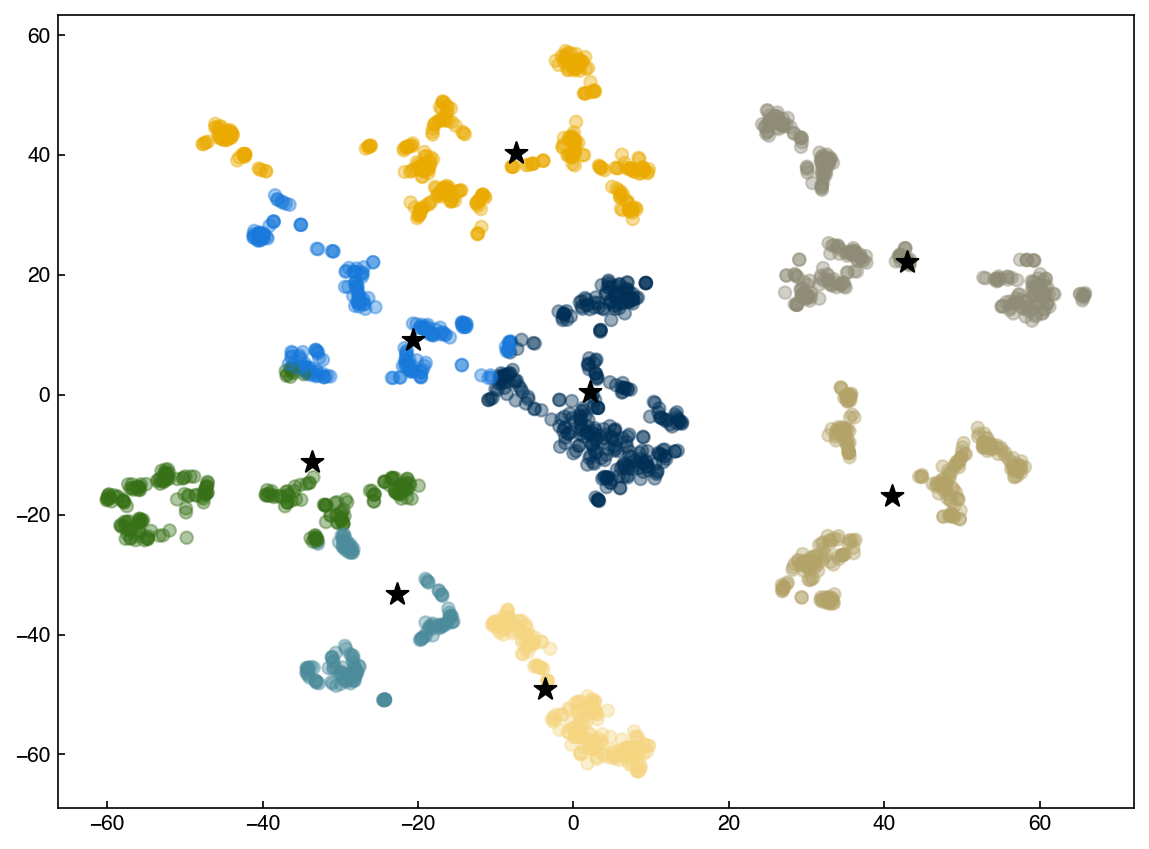

In [33]:
from sklearn.cluster import MeanShift

model = MeanShift(bandwidth = 21)
%time model.fit(X_tsne)
labels = model.labels_
centroids = model.cluster_centers_

fig, ax = plt.subplots()
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c = clrs[labels], alpha = 0.4)
ax.scatter(centroids[:, 0], centroids[:, 1], marker = '*', s = 120, color = 'k');

We see that the results are the same, but `scikit-learn` is much faster. One note is that `scikit-learn` uses some slightly different techniques to speed things up, so `bandwidth` is not the same as `radius`. However, the results are generally similar and the concept is the same.

### DBSCAN

The DBSCAN algorithm also uses a local sliding window similar to mean shift, but instead of defining clusters by centroids it defines the cluster by whether or not a point falls within the sliding window. We will not go through the algorithm in detail, but the general steps are:

1) Start with a random point and find its neigbhors within distance $r$.

2) If there are a sufficient number of neigbhors (defined by a minimum points argument) then the clustering process starts. If not then the point is labeled as noise and a new point is selected until the clustering process starts.

3) The neighbors within a distance $r$ are added to the cluster.

4) The nearest neighbor is selected as the next point, and the same process is repeated until all points within distance $r$ of any point within a cluster are defined as being part of that cluster.

5) Once a cluster has finished, a new point is selected and a new cluster is started. The process is repeated until all points have been assigned to a cluster or labeled as noise.

The key hyperparameters are:
- **r**: the radius to include in a cluster
- **min_samples**: the minimum number of samples within a radius of $\epsilon$ such that a point is not considered noise.
    
The following animation illustrates how the DBSCAN algorithm works:

```{image} ./DBSCAN.gif
:width: 500px
```

The main advantage of DBSCAN is that it can find clusters defined by highly non-linear boundaries, unlike k-means, mean shift, or even GMM's. Let's see how the `scikit-learn` implementation works:

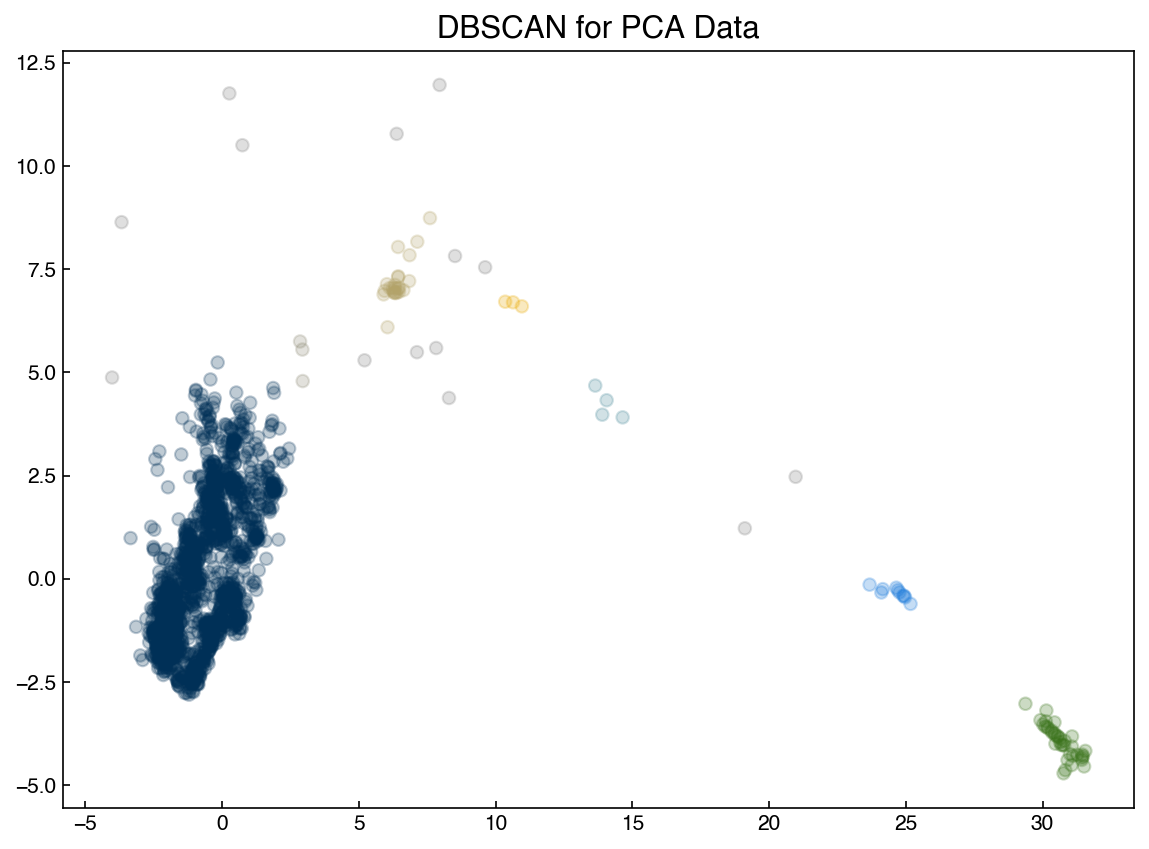

In [34]:
from sklearn.cluster import DBSCAN

X = X_pca

model = DBSCAN(eps = 1, min_samples = 3)
y_predict = model.fit_predict(X)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c = clrs[y_predict], alpha=0.25)
ax.set_title('DBSCAN for PCA Data');

Note that the clustering can be very sensitive to the hyperparameters! These hyperparameters will be related to the density of points, so you may be able to get a good guess based on intuition about the data or by looking at the data. However, some tuning is nearly always necessary.

It is also not possible to predict the cluster of a new point with DBSCAN, which can be a major weakness. One potential solution is to use the DBSCAN output as "classes" and train a classification model, though this adds complexity and the classification model may not be accurate.

## Hierarchical models

The final type of clustering we will discuss are "hierarchical" models. These models construct linkages between different points and use distance cutoffs to assign clusters. Examining the hierarchy of points is a useful way to get insight into the structure of a high-dimensional dataset without dimensional reduction. The downside is that it can be rather slow, since the algorithms scale as $N^3$. However, for the relatively small sizes of datasets typically encountered in engineering it is usually feasible to construct these hierarchies.

### Dendrograms

A "dendrogram" is a graphical representation of the distances between different points in some high-dimensional space. One intuitive but qualitative example of a dendrogram are the [species trees](https://www.instituteofcaninebiology.org/how-to-read-a-dendrogram.html) commonly used in biology:

```{image} ./bio_dendrogram.png
:width: 500px
```

We can see that it is possible to create different "clusters" of species based on different defining characteristics. By choosing more or less specific "cutoffs" we could create a few large clusters or many small clusters. The idea is similar for data sets. Let's see how it looks for some of our examples.

In [35]:
from scipy.cluster.hierarchy import linkage, dendrogram

X = X_pca

Z = linkage(X, method='single')

Lets take a closer look at the "linkage" output:

In [36]:
print('X shape: {}'.format(X.shape))
print('Z shape: {}'.format(Z.shape))
print('Z[0]:', Z[0])

X shape: (2060, 2)
Z shape: (2059, 4)
Z[0]: [6.77000000e+02 6.91000000e+02 9.83256746e-04 2.00000000e+00]


The "linkage" output has 4 members. Each entry corresponds to the formation of a new cluster from smaller clusters, hence there are (n-1) entries (since the first entry involves 2 points, and each iteration adds one more point).

* the first two entries are the index of the two points/clusters that are being combined (point 677 and 691)
* the third entry is the distance between these clusters (0.00098)
* the fourth entry is the total number of points in the new cluster (2 in this case)

Note that we passed a "method" argument into the linkage. This describes the method that is used to calculate the distance between two clusters that have multiple points. There are more details available [here](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage), but a very qualitative descripton of some of the options:

* `single`: take the minimum distance between any two points in the two clusters
* `complete`: take the maximum distance between any two points in the two clusters
* `average`: use an average of distances between points in the two clusters
* `weighted`: weight distances differently between the agglomerated cluster and one being added
* `centriod`: use the distance between cluster centroids
* `ward`: use the distance that minimizes the variance between the clusters

So, which one should we choose? This is where we can use the "cophenetic coefficient", which measures the ratio of the distance in "linkage" space to the distance in the high-dimensional space.

In [37]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

Dij = pdist(X, metric = 'euclidean')
for method in ['single', 'complete', 'average', 'weighted', 'centroid', 'ward']:
    Z = linkage(X, method = method)
    C, coph_dists = cophenet(Z, Dij)
    print('cophenetic coefficient of {}: {}'.format(method, C))

cophenetic coefficient of single: 0.9549424125877355
cophenetic coefficient of complete: 0.9332039766375549
cophenetic coefficient of average: 0.9781265675460892
cophenetic coefficient of weighted: 0.9568082912812889
cophenetic coefficient of centroid: 0.9786287346144893
cophenetic coefficient of ward: 0.8212908347506772


The `dendrogram` function is a visual representation of this "linkage" structure. The "color threshold" tells the dendrogram a distance (y-axis value) below which to identify separate branches of the dendrogram as different colors.

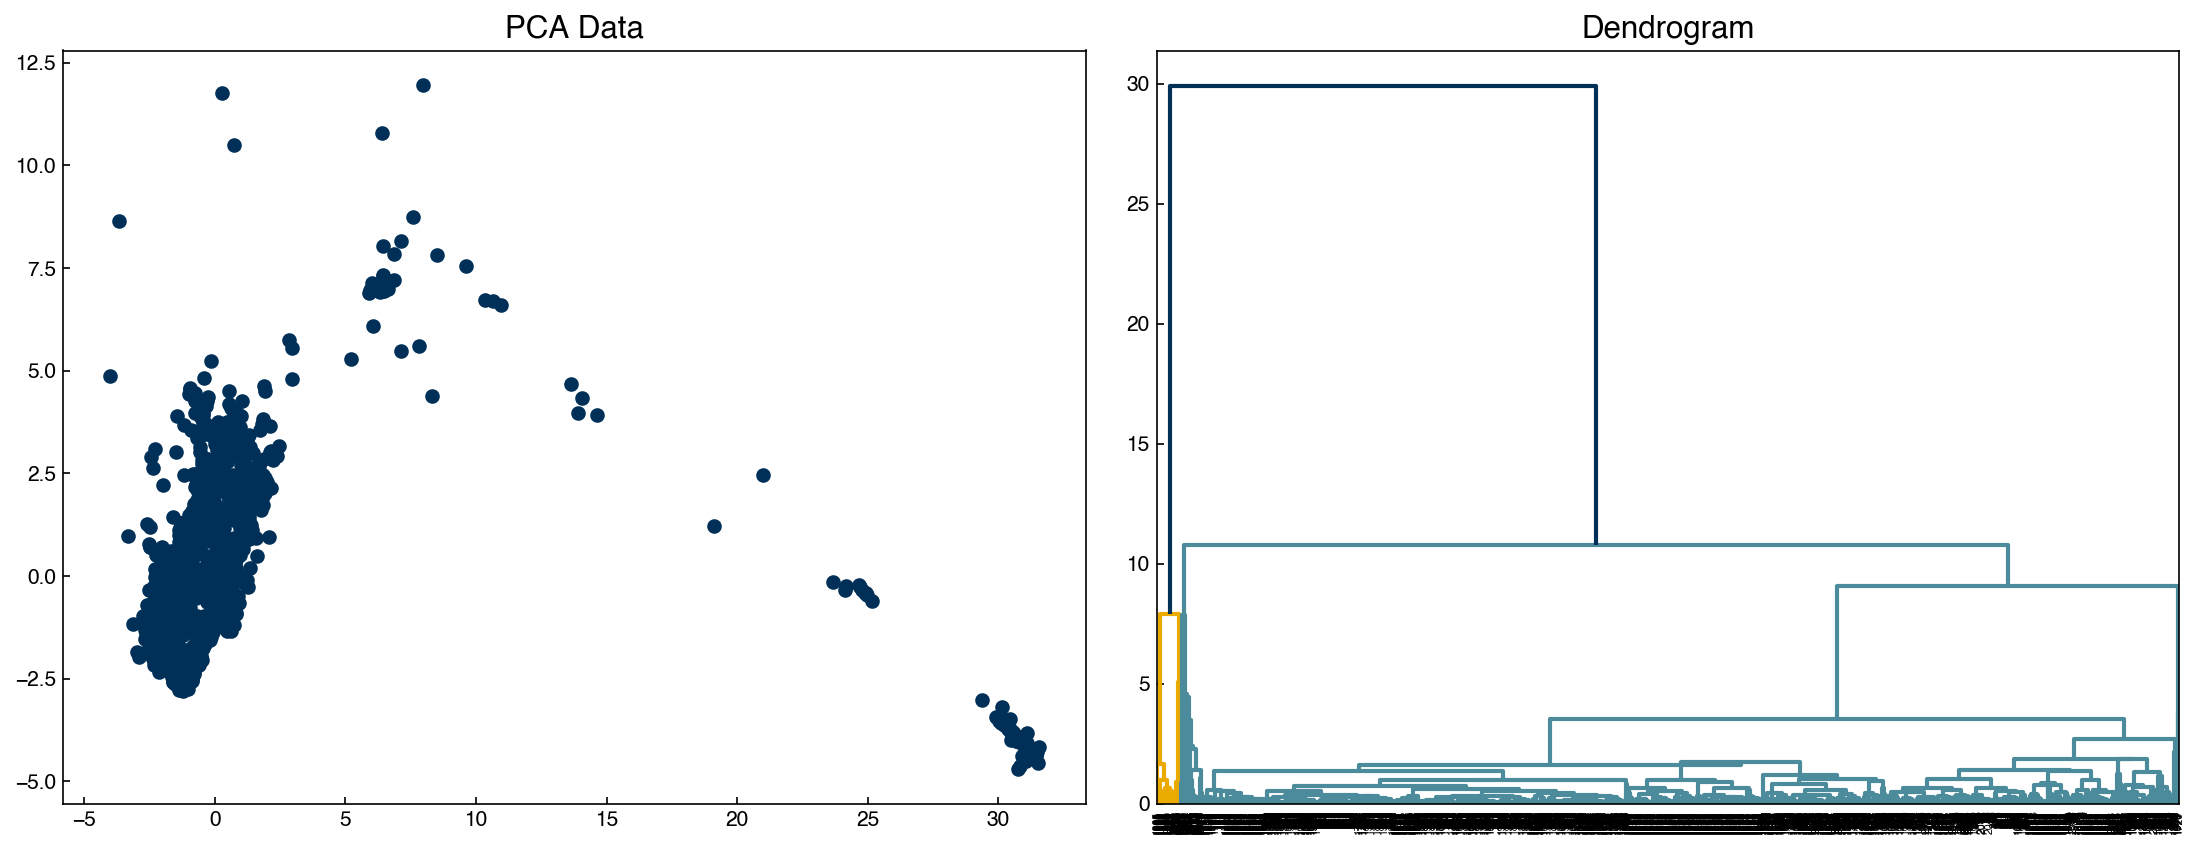

In [38]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
Z = linkage(X, method = 'centroid')
dendrogram(Z, color_threshold = 20, ax = axes[1])
axes[0].scatter(X[:, 0], X[:, 1])
axes[0].set_title('PCA Data')
axes[1].set_title('Dendrogram');

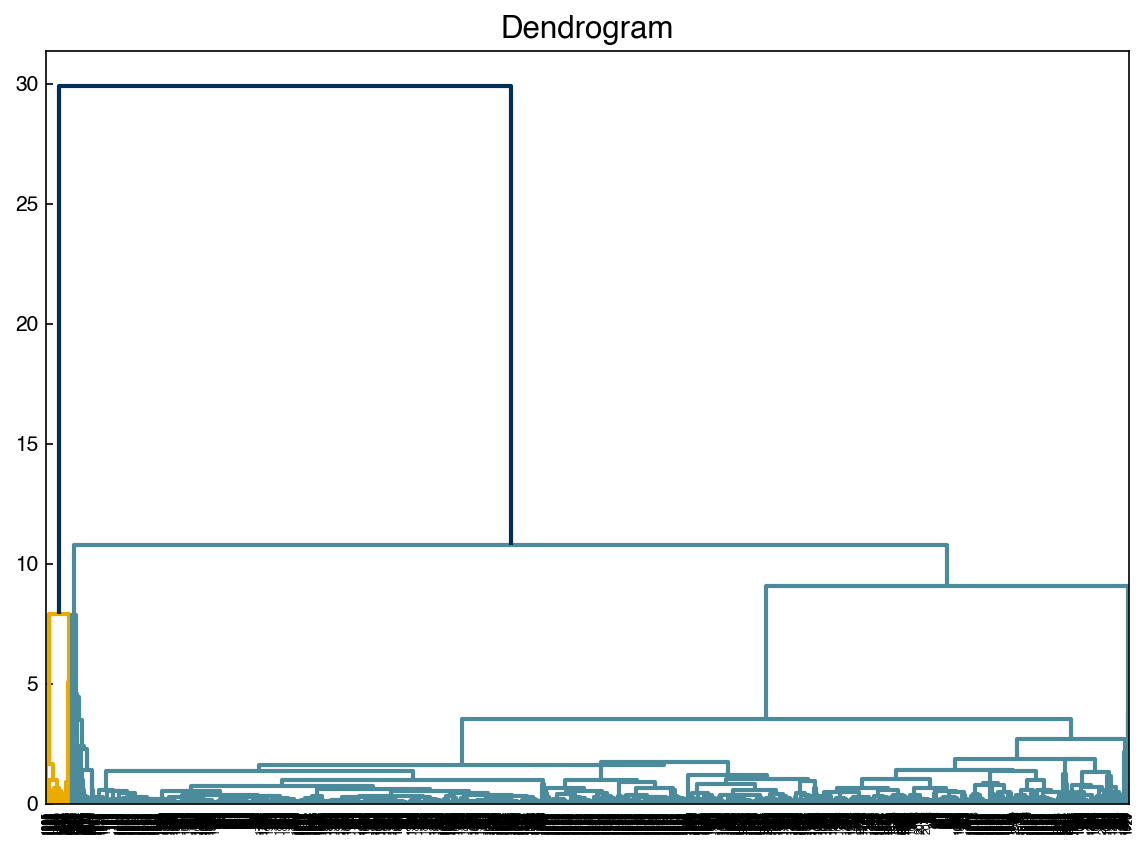

In [39]:
fig, ax = plt.subplots()
dendrogram(Z, color_threshold = 20, ax = ax)
ax.set_title('Dendrogram');

Sometimes it is easier to not show every single datapoint, and truncate the dendrogram:

[7.58000000e+02 1.93700000e+03 6.38691346e-03 2.00000000e+00]


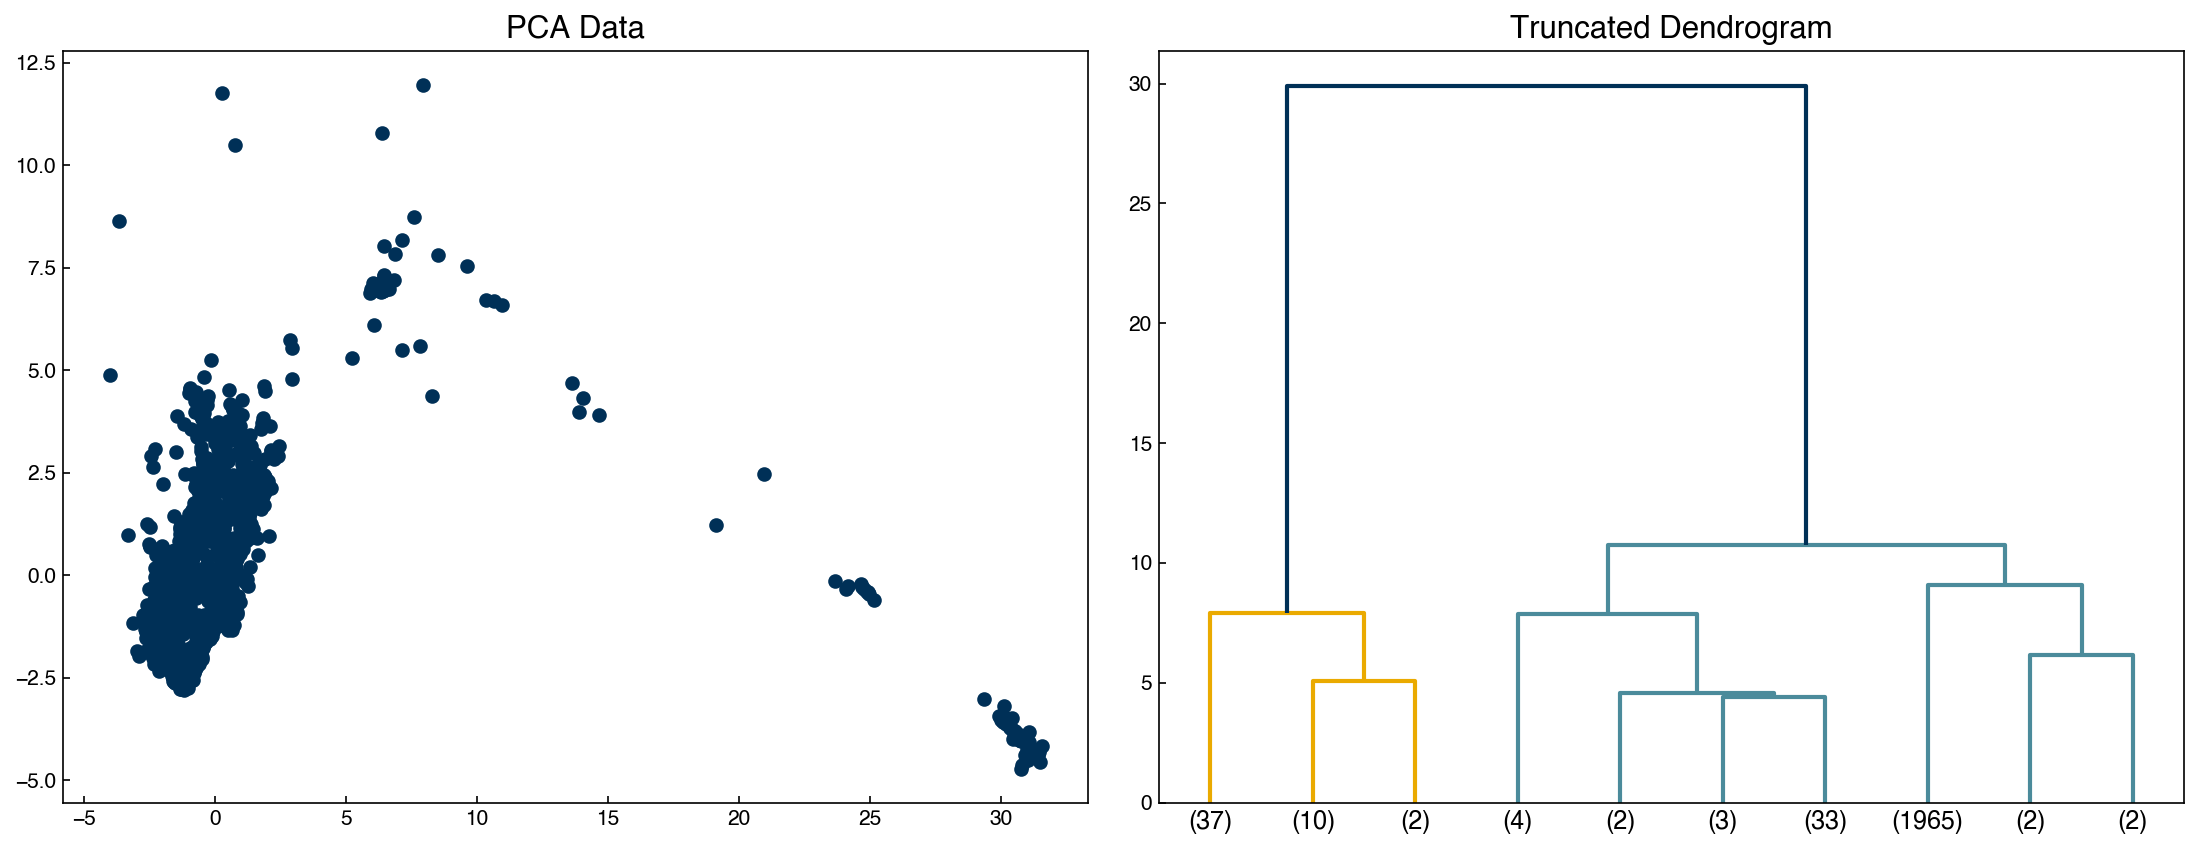

In [40]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
dendrogram(Z, color_threshold = 20, truncate_mode = 'lastp', p = 10, ax = axes[1])
axes[0].scatter(X[:, 0], X[:, 1])
axes[0].set_title('PCA Data')
axes[1].set_title('Truncated Dendrogram');
print(Z[37])

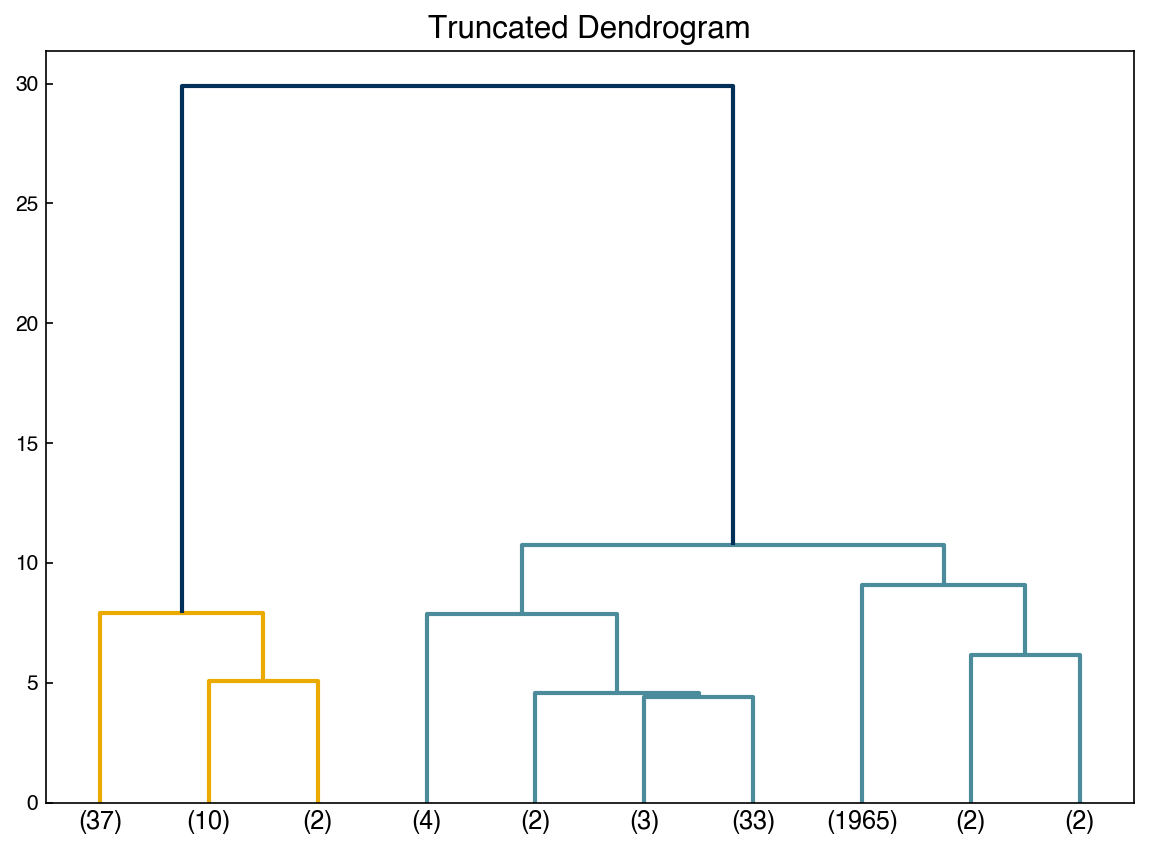

In [41]:
fig, ax = plt.subplots()
dendrogram(Z, color_threshold = 20, truncate_mode = 'lastp', p = 10, ax = ax)
ax.set_title('Truncated Dendrogram');

### Agglomerative hierarchical clustering

Agglomerative clustering is easy to understand once the "linkage" structure makes sense. The number of clusters can be defined either explicitly (move up the tree until there are 'k' clusters) or implicitly (provide a linkage distance that defines separate clusters).

The following animations illustrates this nicely:

```{image} ./agglomerative.gif
:width: 700
```

The mechanics of doing this can be a little tricky, but luckily there are built-in functions to help:

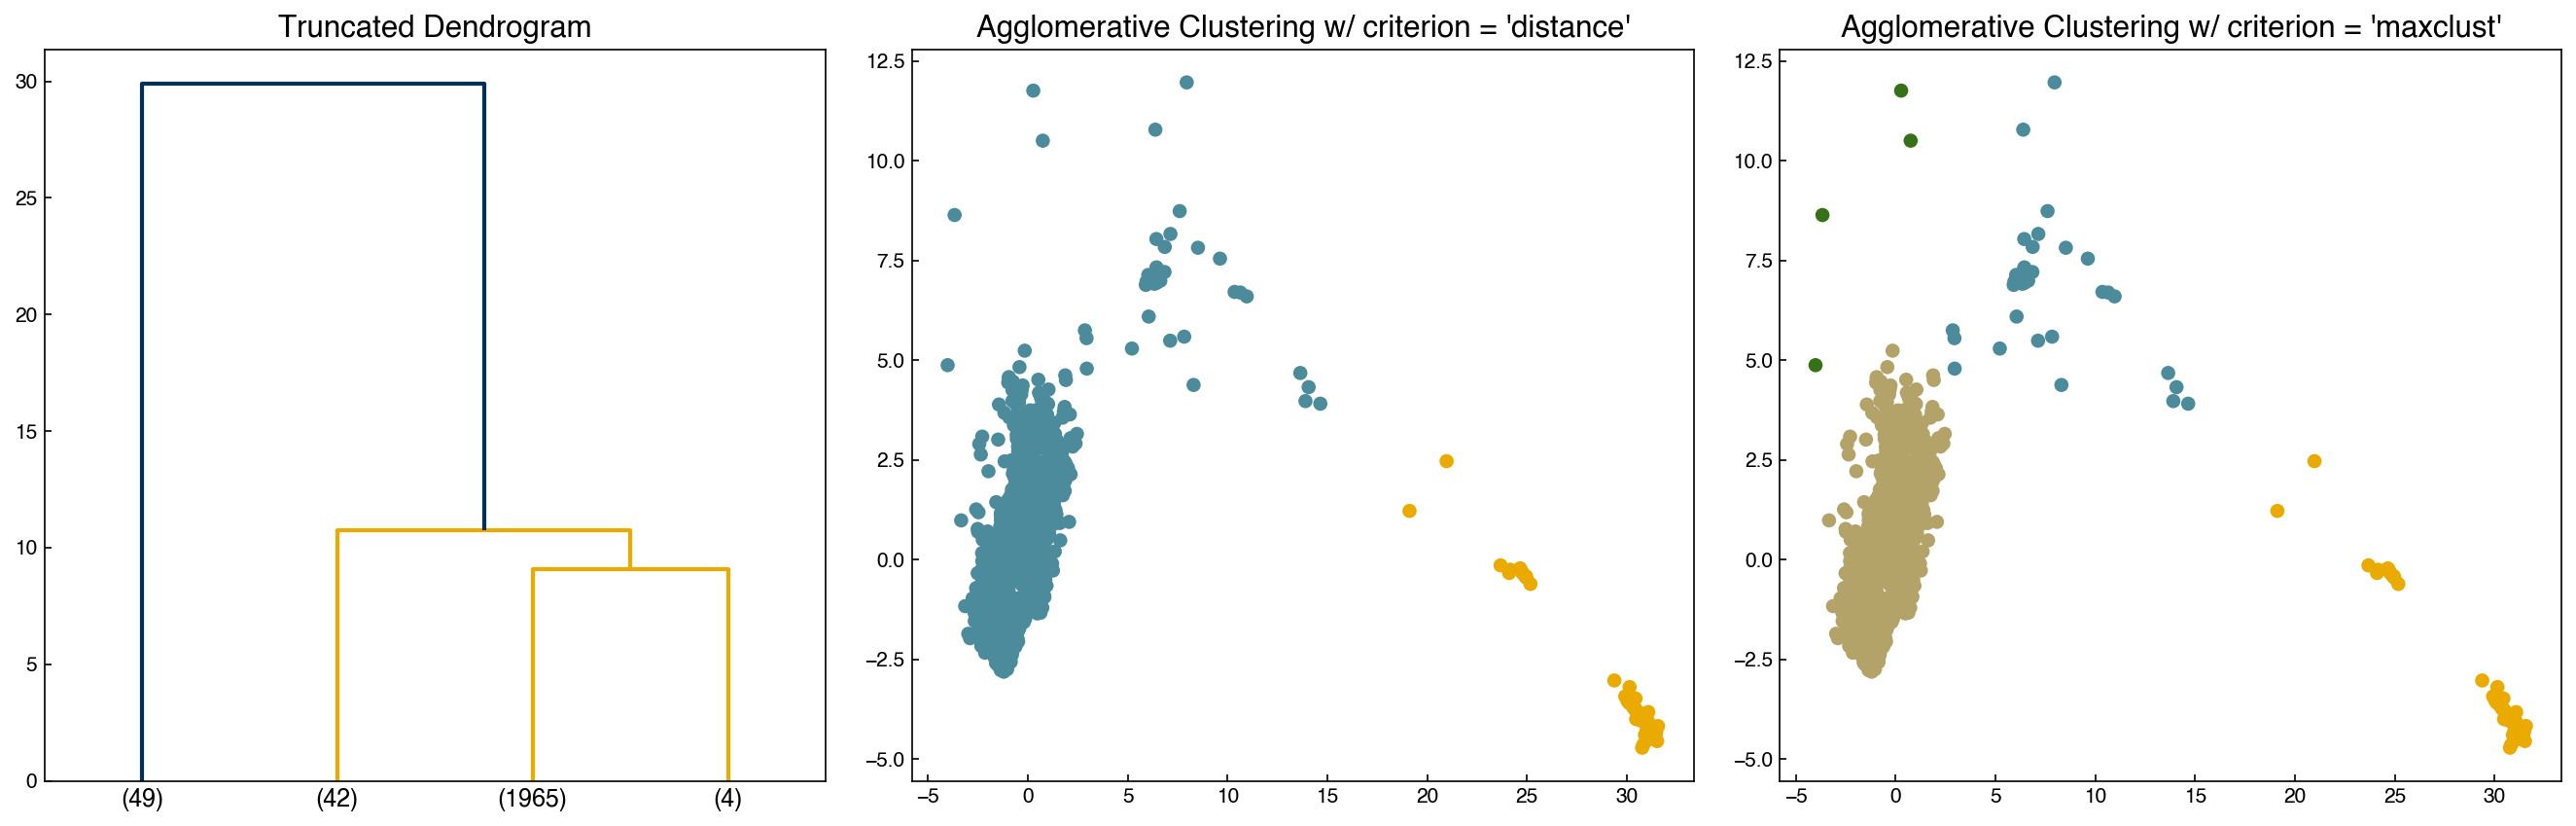

In [42]:
from scipy.cluster.hierarchy import fcluster

max_d = 20
k = 4

clusters_dist = fcluster(Z, max_d, criterion = 'distance')
clusters_k = fcluster(Z, k, criterion = 'maxclust')

fig, axes = plt.subplots(1, 3, figsize = (18, 6))
dendrogram(Z, color_threshold = max_d, truncate_mode = 'lastp', p = k, ax = axes[0])
axes[1].scatter(X[:, 0], X[:, 1], c = clrs[clusters_dist])
axes[2].scatter(X[:, 0], X[:, 1], c = clrs[clusters_k])

axes[0].set_title('Truncated Dendrogram')
axes[1].set_title("Agglomerative Clustering w/ criterion = 'distance'")
axes[2].set_title("Agglomerative Clustering w/ criterion = 'maxclust'");

There are options for determining the cutoffs automatically, but none of them are great! The most common is the inconsistency method, which monitors for "jumps" in the distance:

* $I = \frac{h-avg}{std}$
    - $h$: merge height of cluster (length in y-directon on dendrogram)
    - $avg$: average height of last $d$ merges
    - $std$: standard deviation of last $d$ merges
    
If $I >= t$ where t is a specified threshold then this will be used as the cutoff. Let's see how it performs:

Number of clusters: 5


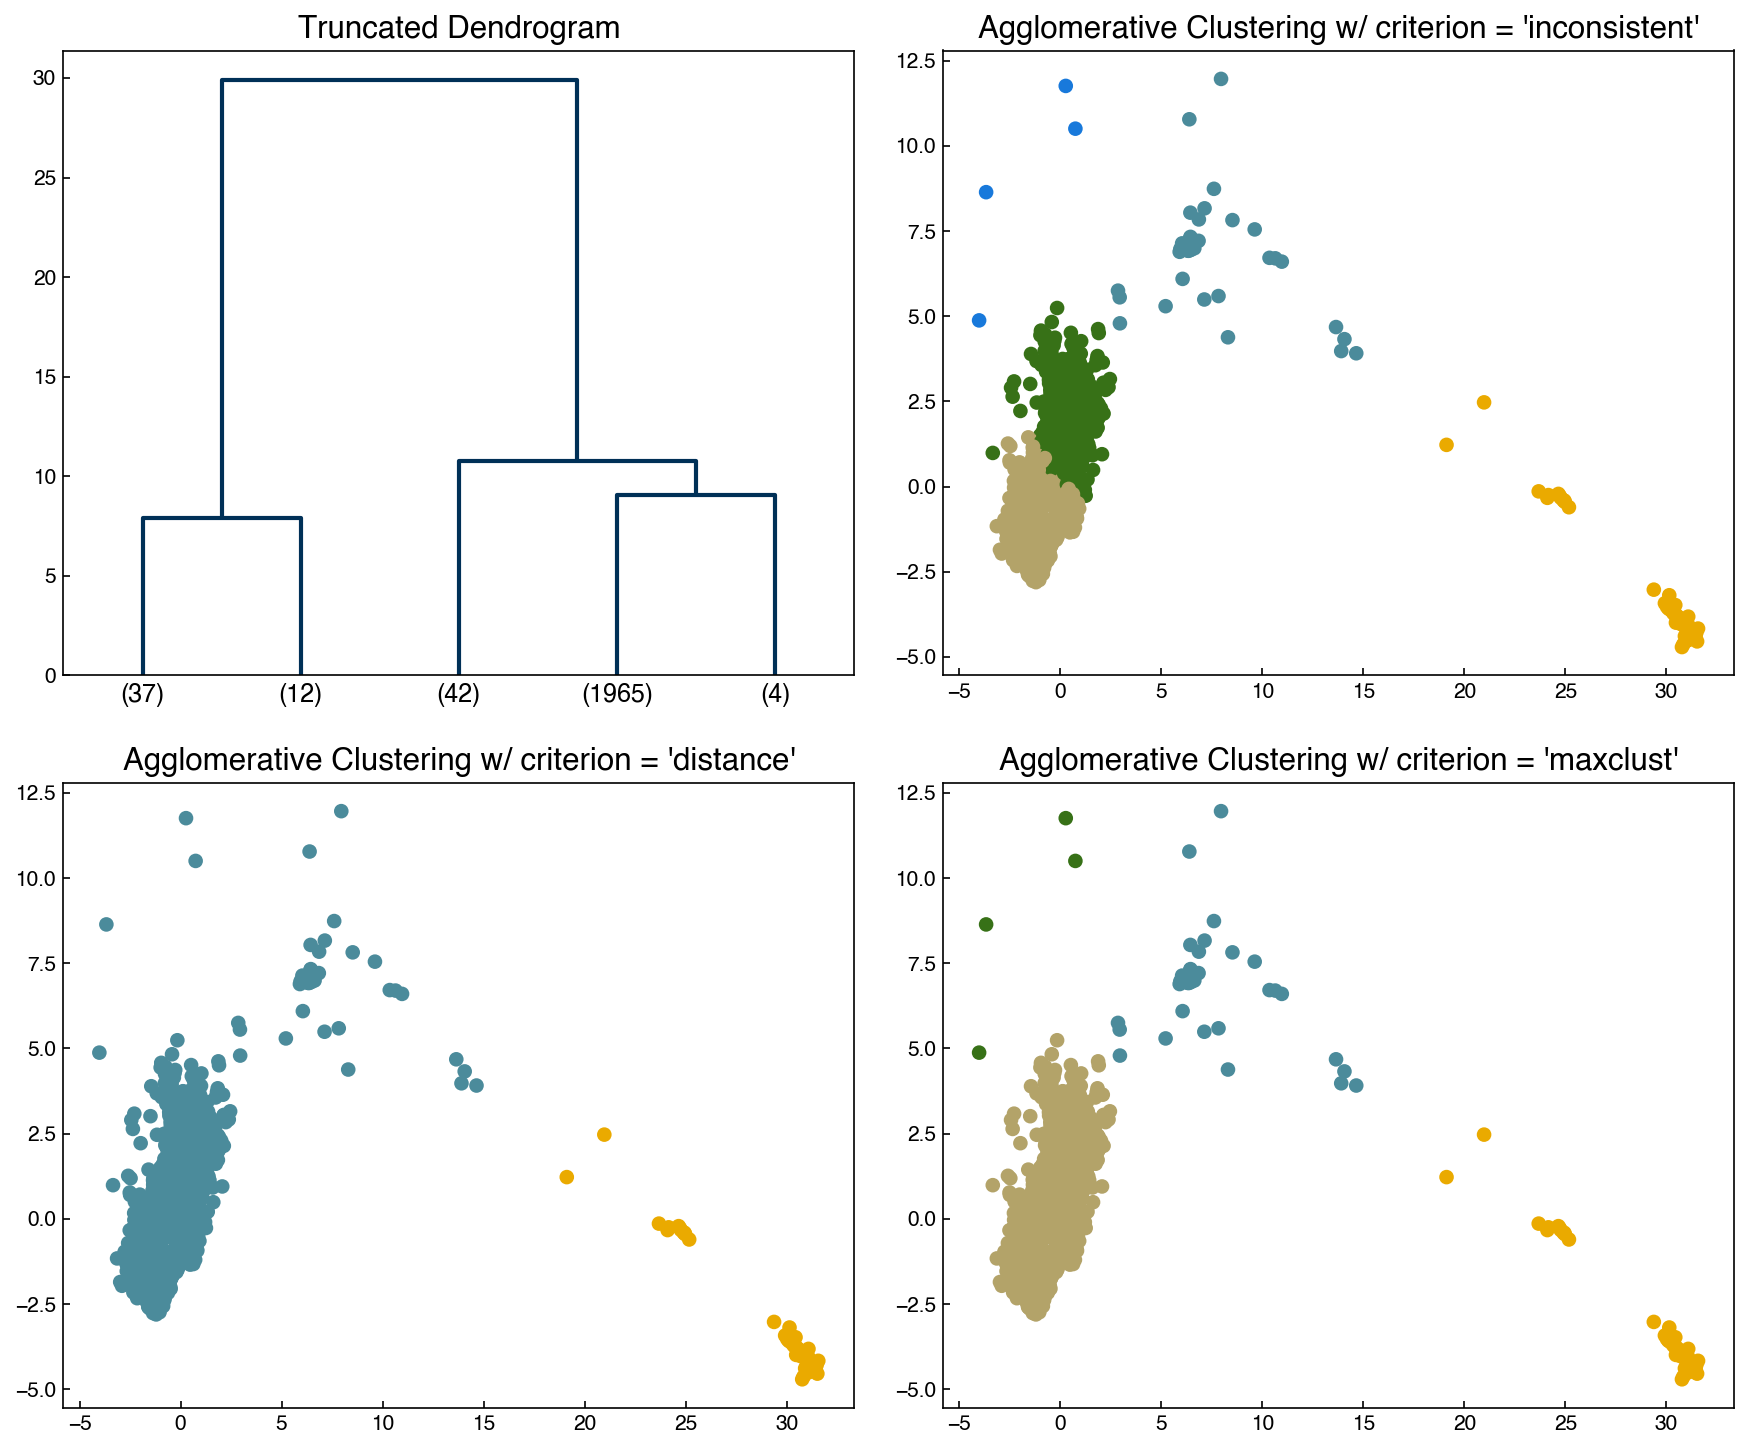

In [43]:
I_cutoff = 9
clusters_I = fcluster(Z, I_cutoff, criterion = 'inconsistent', depth = 10)
n_clusters = max(clusters_I)

fig, axes = plt.subplots(2, 2, figsize = (12, 10))
axes = axes.ravel()
dendrogram(Z, color_threshold = 3, truncate_mode = 'lastp', p = int(n_clusters), ax = axes[0])
axes[1].scatter(X[:, 0], X[:, 1], c = clrs[clusters_I])
axes[2].scatter(X[:, 0], X[:, 1], c = clrs[clusters_dist])
axes[3].scatter(X[:, 0], X[:, 1], c = clrs[clusters_k])

axes[0].set_title('Truncated Dendrogram')
axes[1].set_title("Agglomerative Clustering w/ criterion = 'inconsistent'");
axes[2].set_title("Agglomerative Clustering w/ criterion = 'distance'")
axes[3].set_title("Agglomerative Clustering w/ criterion = 'maxclust'")

print('Number of clusters:', n_clusters)

In practice it is typically best to use some visualization strategy in conjunction with manual and/or automatic strategies to determine a cutoff that makes intuitive sense.